In [1]:
# #### run once before each notebook execution and clear output
# %pip install pandas_datareader 
# %pip install statsmodels
# %pip install linearmodels
# %pip install quantstats
# %pip install wrds
# %pip install pathlib
# %pip install scipy
# %pip install sklearn
# %pip install pandas_datareader 
# %pip install tqdm
# %pip install ZipFile
# %pip install seaborn
# %pip install matplotlib
# %pip install xgboost
# %pip install quandl
# %pip install keras
# %pip install --upgrade tensorflow 
# %pip install shap

# print('############################# completed installations #####################')

In [2]:
# after we install all the packages, import all of them for the use in today's lecture!
# database access
import boto3
from sagemaker import get_execution_role
import s3fs
import h5py
import tempfile

import quandl as quandl
import wrds as wrds
# storage and operations
import pandas as pd
import numpy as np
import datetime
from pathlib import Path
import seaborn as sns

# stats
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from scipy import stats
from scipy.stats.mstats import winsorize
import os
from tqdm import tqdm
from zipfile import ZipFile
import seaborn
import matplotlib.pyplot as plt
import linearmodels as lm
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

#portfolio optimization:
# libraries we might use for testing
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import linearmodels as lm
from linearmodels.panel import compare  
import time
import quantstats as qs
import tensorflow as tf
from tensorflow import keras
import xgboost

from sklearn.metrics import mean_squared_error, r2_score

from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import gc

# path_factors = Path(r'C:\Users\mauri\FSoF\Frankfurt School of Finance - Master Thesis\Master Thesis - Data\Factors')
# path_wrds = Path(r'C:\Users\mauri\FSoF\Frankfurt School of Finance - Master Thesis\Master Thesis - Data\WRDS')
# path_ml = Path(r'C:\Users\mauri\FSoF\Frankfurt School of Finance - Master Thesis\Master Thesis - Machine Learning Models')
# path_visual = Path(r'C:\Users\mauri\FSoF\Frankfurt School of Finance - Master Thesis\Master Thesis - Visualisation/')
# path_betas = Path(r'C:\Users\mauri\FSoF\Frankfurt School of Finance - Master Thesis\Master Thesis - Data\Factor Betas')

# factor_data = path_factors / 'factor_data.h5'
# macro_data = path_factors / 'macro_data.h5'
# wrds_data = path_wrds / 'wrds_data.h5'
# saved_models = path_ml / 'saved_ml_models.h5'

#bucket s3 AWS
path_bucket = 's3://mm-master-thesis-data/'
path_bucket_ml = 's3://mm-master-thesis-data/ml-models/'

#factor data 
factor_data = path_bucket + "monthly_factor_data.csv"
factor_data_adj = path_bucket + 'monthly_factors_adjusted.csv'
factor_data_base = path_bucket + 'monthly_factors_base.csv'
factor_data_base_extended = path_bucket + 'monthly_factors_base_extended.csv'

benchmark_ff = path_bucket + 'benchmark_factor_data.csv'
benchmark_bk = path_bucket + 'benchmark_factor_data_bkelly.csv'

#macro data 
macro_data = path_bucket + 'macro_data.csv'

# stock data
wrds_data_file = path_bucket +'wrds_data_complete_abs.csv' 
wrds_data_file_wins = path_bucket + 'monthly_wrds_data_complete_wins.csv'
wrds_data_file_wins_quin = path_bucket + 'monthly_stock_data_wins_quin.csv'
wrds_data_file_final = path_bucket + 'monthly_stock_data_final.csv'

#pca factors
pca_factor_path = path_bucket + 'monthly_pca_factors.csv'


# prediction results
OLS_df = path_bucket + 'ols_results.csv'
Ridge_df = path_bucket + 'ridge_results.csv'
Lasso_df = path_bucket + 'lasso_results.csv'

2022-08-28 16:31:14.146505: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-28 16:31:14.146541: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
tf.version.VERSION

'2.9.1'

In [4]:
def file_saver(data_object, data_name_as_string):
    saver = boto3.Session().resource('s3').Bucket('mm-master-thesis-data').Object(data_object).upload_file(data_name_as_string)

In [5]:
def winsorizer(df, columns, limits):
    
    winsorized_df = df.copy(deep=True)
    for c in columns:
        goods    = winsorized_df[c].notna()
        winsorized_df.loc[goods,c] = winsorize(winsorized_df.loc[goods,c], limits=limits)

    return winsorized_df

def find_min_max(df, number_of_extremes, variable):
    if isinstance(df,pd.DataFrame):

        max_df_returns = df.max().tolist()
        max_df_returns.sort(reverse=True)
        number_max_returns = max_df_returns[:number_of_extremes]
        number_max_returns = [ '%.2f' % elem for elem in number_max_returns ]
        print('The', number_of_extremes, 'highest', variable, 'are: ') 
        print(number_max_returns)
        print('')
        min_df_returns = df.min().tolist()
        min_df_returns.sort()
        number_min_returns = min_df_returns[:number_of_extremes]
        number_min_returns = [ '%.2f' % elem for elem in number_min_returns ]
        print('The', number_of_extremes, 'lowest', variable, 'are: ') 
        print(number_min_returns)
    elif isinstance(df,pd.Series):
        max_df_returns = df.values.tolist()
        max_df_returns.sort(reverse=True)
        number_max_returns = max_df_returns[:number_of_extremes]
        number_max_returns = [ '%.2f' % elem for elem in number_max_returns ]
        print('The', number_of_extremes, 'highest', variable, 'are: ') 
        print(number_max_returns)
        print('')
        min_df_returns = df.values.tolist()
        min_df_returns.sort()
        number_min_returns = min_df_returns[:number_of_extremes]
        number_min_returns = [ '%.2f' % elem for elem in number_min_returns ]
        print('The', number_of_extremes, 'lowest', variable, 'are: ') 
        print(number_min_returns)

# Macro Factors

In [6]:
macro_factors = pd.read_csv(macro_data)
macro_factors = macro_factors.set_index('date',drop=True)
macro_factors = macro_factors.applymap(lambda x: f'{x:.3f}')
macro_factors = macro_factors.drop(columns=['Unnamed: 0'])
macro_factors = macro_factors.astype(float)
macro_factors

,D12,E12,bm,tbl,lty,ntis,Rfree,infl,ltr,corpr,...,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
date,,,,,,,,,,,,,,,,,,,,,
1977-07,4.407,10.517,0.897,0.052,0.077,0.033,0.004,0.005,-0.007,-0.001,...,85.536,35.172,24.873,5.97,7.54,5.58,12900.00,35574.00,230.302,15.362
1977-08,4.453,10.613,0.927,0.055,0.075,0.034,0.004,0.003,0.020,0.014,...,85.817,35.270,25.027,5.99,7.56,5.61,13058.00,36030.00,230.172,14.493
1977-09,4.500,10.710,0.942,0.058,0.076,0.032,0.004,0.003,-0.003,-0.002,...,85.946,35.317,25.173,6.03,7.62,5.65,13177.00,36241.00,230.965,14.087
1977-10,4.557,10.770,0.975,0.062,0.078,0.033,0.005,0.003,-0.009,-0.004,...,86.439,35.456,25.293,6.08,7.66,5.69,14686.00,37965.00,229.856,15.454
1977-11,4.613,10.830,0.962,0.061,0.078,0.029,0.005,0.005,0.009,0.006,...,86.802,35.699,25.434,6.11,7.68,5.72,14975.00,38553.00,231.645,19.638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08,59.129,98.557,0.236,0.001,0.006,-0.009,0.000,0.003,-0.035,-0.049,...,86.662,98.675,120.600,25.50,29.43,22.85,344023.25,726723.85,4385.243,22.879
2020-09,58.851,98.220,0.241,0.001,0.007,-0.006,0.000,0.001,0.008,0.004,...,86.616,98.508,120.964,25.46,29.11,23.00,347627.43,730734.42,4452.042,27.587
2020-10,58.660,96.857,0.253,0.001,0.008,-0.002,0.000,0.000,-0.024,-0.019,...,86.532,98.398,121.094,25.54,29.31,22.99,348262.68,730398.69,4514.528,29.436


# Factor Data

In [7]:
monthly_factors = pd.read_csv(factor_data)
monthly_factors= monthly_factors.set_index('date',drop=True)
monthly_factors = monthly_factors.applymap(lambda x: f'{x:.3f}')
monthly_factors= monthly_factors.astype('float')
monthly_factors= monthly_factors.drop(columns=['Unnamed: 0','poa_y','rf'])
monthly_factors= monthly_factors.rename(columns={'poa_x':'poa'})
monthly_factors= monthly_factors.loc[(monthly_factors.index>=('1977-01'))&(monthly_factors.index<=('2020-12'))]
monthly_factors

,0trade,abr_1,aci,adm,almq_1,amihud,atoq_1,bab,bm,bmj,...,ta,vfp,vhp,dtv_12,fp_6,iaq_12,p52w_6,r6_1,resid6,tbiq_12
date,,,,,,,,,,,,,,,,,,,,,
1977-07,0.019,-0.005,-0.021,0.013,-0.017,0.013,0.011,0.029,-0.011,-0.004,...,-0.006,0.009,-0.008,-0.011,-0.009,-0.007,0.008,-0.016,0.001,0.015
1977-08,-0.006,0.017,-0.004,-0.004,-0.017,0.001,0.018,0.003,-0.034,-0.033,...,0.016,-0.006,-0.030,-0.066,-0.025,0.017,-0.018,-0.012,-0.017,-0.003
1977-09,0.010,0.018,-0.003,-0.008,-0.005,0.012,-0.007,0.004,-0.002,-0.014,...,0.011,-0.010,0.019,-0.071,-0.022,0.005,0.022,0.025,0.007,0.013
1977-10,0.011,-0.007,-0.006,0.012,0.016,0.017,-0.000,0.002,0.014,0.019,...,0.007,-0.108,0.011,0.055,-0.008,0.000,0.010,-0.007,0.003,0.008
1977-11,-0.031,0.032,-0.010,0.001,0.024,0.041,0.007,0.003,0.011,0.004,...,0.004,0.029,0.004,-0.005,0.013,-0.014,-0.005,0.026,0.007,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08,-0.049,0.018,-0.011,0.000,0.009,-0.014,0.030,-0.040,-0.010,0.032,...,-0.001,-0.006,0.038,0.036,0.006,0.023,-0.011,-0.034,-0.025,0.022
2020-09,-0.006,0.006,-0.013,-0.010,-0.004,-0.005,0.011,0.013,-0.028,-0.063,...,0.020,-0.006,0.006,0.141,-0.018,0.012,0.049,0.043,-0.014,-0.030
2020-10,-0.012,-0.003,0.008,0.045,0.056,0.041,0.002,-0.020,0.025,0.043,...,-0.000,0.005,0.002,-0.036,0.003,-0.000,-0.027,-0.014,-0.006,-0.013


In [8]:
monthly_factors_adj = pd.read_csv(path_bucket+'monthly_factors_adjusted.csv')
monthly_factors_adj = monthly_factors_adj.set_index('date',drop=True)
monthly_factors_adj = monthly_factors_adj.applymap(lambda x: f'{x:.3f}')
monthly_factors_adj = monthly_factors_adj.astype('float')
monthly_factors_adj= monthly_factors_adj.loc[(monthly_factors_adj.index>=('1977-01'))&(monthly_factors_adj.index<=('2020-12'))]

monthly_factors_adj.head()

,abr_1,aci,amihud,bab,def_1,dfin,dii,dlno,dsre,ep,...,pda,poa,qmj,r1a,rer,rev_1,roe_1,sm_1,dtv_12,tbiq_12
date,,,,,,,,,,,,,,,,,,,,,
1977-07,-0.005,-0.021,0.013,0.029,0.026,0.007,-0.016,0.002,-0.004,0.001,...,-0.005,0.005,-0.008,0.013,0.012,-0.016,0.018,-0.012,-0.011,0.015
1977-08,0.017,-0.004,0.001,0.003,0.004,0.020,0.001,0.001,-0.008,-0.035,...,-0.002,0.010,0.009,0.021,-0.007,-0.023,0.018,0.004,-0.066,-0.003
1977-09,0.018,-0.003,0.012,0.004,0.057,0.000,0.000,0.013,-0.007,0.014,...,0.011,0.007,0.031,0.008,0.002,-0.014,0.023,-0.011,-0.071,0.013
1977-10,-0.007,-0.006,0.017,0.002,0.009,0.007,0.003,-0.005,-0.004,0.015,...,-0.000,0.010,0.004,0.013,0.019,0.008,-0.013,-0.010,0.055,0.008
1977-11,0.032,-0.010,0.041,0.003,0.021,0.017,-0.003,-0.019,-0.007,-0.000,...,-0.010,-0.009,0.011,0.019,-0.014,-0.034,0.042,0.017,-0.005,0.001


In [9]:
monthly_factors_base = pd.read_csv(path_bucket+'monthly_factors_base.csv')
monthly_factors_base = monthly_factors_base.set_index('date',drop=True)
monthly_factors_base = monthly_factors_base.applymap(lambda x: f'{x:.3f}')
monthly_factors_base = monthly_factors_base.astype('float')
monthly_factors_base= monthly_factors_base.loc[(monthly_factors_base.index>=('1977-01'))&(monthly_factors_base.index<=('2020-12'))]

monthly_factors_base.head()

,abr_1,aci,amihud,bab,cla,ctoq_1,def_1,dfin,dii,dlno,...,qmj,r1a,rer,rev_1,roa_1,roe_1,sm_1,sp,dtv_12,tbiq_12
date,,,,,,,,,,,,,,,,,,,,,
1977-07,-0.005,-0.021,0.013,0.029,0.024,0.003,0.026,0.007,-0.016,0.002,...,-0.008,0.013,0.012,-0.016,0.012,0.018,-0.012,-0.005,-0.011,0.015
1977-08,0.017,-0.004,0.001,0.003,0.022,0.017,0.004,0.020,0.001,0.001,...,0.009,0.021,-0.007,-0.023,0.022,0.018,0.004,-0.027,-0.066,-0.003
1977-09,0.018,-0.003,0.012,0.004,0.022,-0.007,0.057,0.000,0.000,0.013,...,0.031,0.008,0.002,-0.014,0.013,0.023,-0.011,-0.007,-0.071,0.013
1977-10,-0.007,-0.006,0.017,0.002,0.003,-0.003,0.009,0.007,0.003,-0.005,...,0.004,0.013,0.019,0.008,-0.007,-0.013,-0.010,0.006,0.055,0.008
1977-11,0.032,-0.010,0.041,0.003,0.007,0.018,0.021,0.017,-0.003,-0.019,...,0.011,0.019,-0.014,-0.034,0.035,0.042,0.017,0.012,-0.005,0.001


# Stock Data

In [10]:
monthly_stock_data = pd.read_csv(wrds_data_file_final)
monthly_stock_data = monthly_stock_data.loc[(monthly_stock_data.date>=('1977-01'))&(monthly_stock_data.date<=('2020-12'))]
monthly_stock_data = monthly_stock_data.set_index('date')

## Adding s&p 500 components

In [11]:
component_list = pd.read_csv(path_bucket+'sp500_permnos.csv')
component_list.drop(columns=['Unnamed: 0'], inplace=True)
component_list =  component_list.rename(columns={'0':'permno'})
len(component_list.permno.unique())

583

In [12]:
monthly_stock_data = monthly_stock_data.loc[monthly_stock_data.permno.isin(component_list.permno.unique())]
len(monthly_stock_data.permno.unique())

501

In [13]:
# monthly_stock_data
# data_to_scale = np.array(monthly_stock_data['fwd_quintile'])
# data_to_scale = data_to_scale.reshape(-1,1)

# scaler = MinMaxScaler()
# scaled_data = scaler.fit_transform(data_to_scale)
# monthly_stock_data['scaled_Y'] = scaled_data
# monthly_stock_data

## For Categorization purposes the quintiles need to be shifted by one

In [14]:
monthly_stock_data['fwd_quintile_adj'] = monthly_stock_data['fwd_quintile']-1
monthly_stock_data
    

,permno,prc,ret,shrout,mktcap,vweights,ret_mk,monthly_exret,fwd_monthly_exret,quintile,fwd_quintile,fwd_quintile_adj
date,,,,,,,,,,,,
1986-04,10104.0,25.000000,0.197605,13189.0,3.297250e+05,0.000139,-0.002530,0.200135,-0.113263,4,4,3
1986-05,10104.0,23.500000,-0.060000,13189.0,3.099415e+05,0.000142,0.053263,-0.113263,0.016762,4,4,3
1986-06,10104.0,24.375000,0.037234,13189.0,3.214819e+05,0.000096,0.020472,0.016762,-0.314516,4,3,2
1986-07,10104.0,15.500000,-0.335632,13189.0,2.044295e+05,0.000096,-0.049587,-0.314516,-0.009569,3,3,2
1986-08,10104.0,16.500000,0.064516,13242.0,2.184930e+05,0.000090,0.074085,-0.009569,-0.060247,3,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06,92655.0,294.950012,-0.028375,948380.0,2.797247e+08,0.008455,0.027283,-0.055658,-0.033264,5,5,4
2020-07,92655.0,302.779999,0.026547,948380.0,2.871505e+08,0.008236,0.059811,-0.033264,-0.037238,5,5,4
2020-08,92655.0,312.549988,0.032268,950336.0,2.970275e+08,0.008534,0.069506,-0.037238,0.033372,5,5,4


In [15]:
print('total prediction months: ', len(monthly_stock_data.index.unique()))
print('total number of stocks: ', len(monthly_stock_data.permno.unique()))

total prediction months:  520
total number of stocks:  501


# Prediction Config 

In [16]:
final_stock_data = monthly_stock_data.copy(deep=True)
final_factor_data = monthly_factors_adj.copy(deep=True)
final_macro_data = macro_factors.copy(deep=True)

window =  252*3
min_len = 200
batch_size = 8
n_factors = len(final_factor_data.columns)
patience_value = 25

start_date = ('1977-01')
end_date = ('2020-10')
Y_name = 'fwd_quintile_adj'


label_names = np.sort(final_stock_data[Y_name].unique())
label_names

array([0, 1, 2, 3, 4])

# Neural Network Model Construction

Saving all model processes in a file to continue training the model with previous weights 

### local savings version

In [17]:
checkpoints_loop = 'checkpoints_loop/'

checkpoints_LSTM_model_merged_1L_loop = checkpoints_loop+'checkpoints_LSTM_model_merged_1L_loop.h5'
checkpoints_LSTM_model_merged_2L_loop = checkpoints_loop+'checkpoints_LSTM_model_merged_2L_loop.h5'
checkpoints_LSTM_model_merged_3L_loop = checkpoints_loop+'checkpoints_LSTM_model_merged_3L_loop.h5'
checkpoints_LSTM_model_merged_4L_loop = checkpoints_loop+'checkpoints_LSTM_model_merged_4L_loop.h5'

checkpoints_LSTM_model_1L_loop = checkpoints_loop+'checkpoints_LSTM_model_1L_loop.h5'
checkpoints_LSTM_model_2L_loop = checkpoints_loop+'checkpoints_LSTM_model_2L_loop.h5'
checkpoints_LSTM_model_3L_loop = checkpoints_loop+'checkpoints_LSTM_model_3L_loop.h5'
checkpoints_LSTM_model_4L_loop = checkpoints_loop+'checkpoints_LSTM_model_4L_loop.h5'

checkpoints_FFN_model_L1_loop = checkpoints_loop+'checkpoints_FFN_model_L1_loop.h5'
checkpoints_FFN_model_L2_loop = checkpoints_loop+'checkpoints_FFN_model_L2_loop.h5'
checkpoints_FFN_model_L3_loop = checkpoints_loop+'checkpoints_FFN_model_L3_loop.h5'
checkpoints_FFN_model_L4_loop = checkpoints_loop+'checkpoints_FFN_model_L4_loop.h5'

checkpoints_model_merged_1L_loop = checkpoints_loop+'checkpoints_model_merged_1L_loop.h5'
checkpoints_model_merged_2L_loop = checkpoints_loop+'checkpoints_model_merged_2L_loop.h5'
checkpoints_model_merged_3L_loop = checkpoints_loop+'checkpoints_model_merged_3L_loop.h5'
checkpoints_model_merged_4L_loop = checkpoints_loop+'checkpoints_model_merged_4L_loop.h5'

checkpoints_model_1L_loop = checkpoints_loop+'checkpoints_model_1L_loop.h5'
checkpoints_model_2L_loop = checkpoints_loop+'checkpoints_model_2L_loop.h5'
checkpoints_model_3L_loop = checkpoints_loop+'checkpoints_model_3L_loop.h5'
checkpoints_model_4L_loop = checkpoints_loop+'checkpoints_model_4L_loop.h5'



number_of_factors = final_factor_data.shape[1]
number_of_macro_factors = final_macro_data.shape[1] 
number_of_merged_factors = number_of_factors+number_of_macro_factors 

print('The dataset has: ', \
     number_of_factors, 'Smart-beta factors, ', \
     number_of_macro_factors, 'Macro factors, ', 'and',
     number_of_merged_factors, 'Total factors, ')

The dataset has:  33 Smart-beta factors,  136 Macro factors,  and 169 Total factors, 


# Data Creation: Tensor Generation

In [18]:
def batch_generator_train(stock_data,macro_data, factor_data, batch_size, train_set_ratio, Y_name):
    """
    model = NN model, 
    data = stock data, factor data, macro data,
    batch_size = timesteps per batch
    alpha adam = learning rate optimizer
    data set ratios = train_set_ratio, val_set_ratio (eg. 0.5)
    """
    
    permno_list = stock_data.permno.unique()

    counter = 0
    
    train_data_factors_arr = []
    train_data_macro_arr = []
    train_data_merged_arr = []
    train_data_y_arr = []
    
    for p in tqdm(permno_list):
        
        stock_data_length = len(stock_data.loc[stock_data.permno==p])
        train_data_stocks = stock_data.loc[stock_data.permno==p][0:int(stock_data_length*train_set_ratio)]
        train_date_index = train_data_stocks.index.values.tolist() 
        
        
        #train data
        train_data_factors = factor_data.loc[factor_data.index.isin(train_date_index)]
        train_data_macro = macro_factors.loc[macro_factors.index.isin(train_date_index)]
        train_data_macro_norm = train_data_macro.copy(deep=True)
        
        for c in train_data_macro_norm.columns: 
            train_data_macro_norm[c] = MinMaxScaler([-1,1]).fit_transform(pd.DataFrame(train_data_macro_norm[c]))
        
        train_data_merged = pd.concat([train_data_factors, train_data_macro_norm],axis=1)
    
        
        x_train_factors = []
        x_train_macro = []
        x_train_merged =[]
        y_train =[]
        

        for i in range(batch_size, len(train_data_factors)):
            x_train_factors.append(train_data_factors.values[i-batch_size:i,:])
            x_train_macro.append(train_data_macro_norm.values[i-batch_size:i,:])
            x_train_merged.append(train_data_merged.values[i-batch_size:i,:])
            y_train.append(train_data_stocks[Y_name].values[i])   #y_train_encoded_arr[i]
  
        x_train_factors, x_train_macro, x_train_merged, y_train= np.array(x_train_factors),np.array(x_train_macro),np.array(x_train_merged), np.array(y_train)

        train_data_factors_arr.append(x_train_factors)
        train_data_macro_arr.append(x_train_macro)
        train_data_merged_arr.append(x_train_merged)
        train_data_y_arr.append(y_train)

        
    return train_data_factors_arr, train_data_macro_arr, train_data_merged_arr, train_data_y_arr

In [19]:
x_train_factors, x_train_macro, x_train_merged, y_train= batch_generator_train(final_stock_data,final_macro_data, final_factor_data, batch_size, 0.8, Y_name)

100%|██████████| 501/501 [02:07<00:00,  3.94it/s]


In [20]:
x_train_factors, x_train_macro, x_train_merged, y_train = np.array(x_train_factors, dtype='object'), np.array(x_train_macro, dtype='object'),np.array(x_train_merged, dtype='object'),np.array(y_train, dtype='object')

In [21]:
print('save train data')
np.savez_compressed('train_arrays_seperate_sp.npz',x_train_factors=x_train_factors,x_train_macro=x_train_macro,x_train_merged=x_train_merged,y_train=y_train)
file_saver('train_arrays_seperate_sp.npz','train_arrays_seperate_sp.npz')

save train data


In [22]:
def batch_generator_test(stock_data,macro_data, factor_data, batch_size, train_set_ratio, Y_name):
    """
    model = NN model, 
    data = stock data, factor data, macro data,
    batch_size = timesteps per batch
    alpha adam = learning rate optimizer
    data set ratios = train_set_ratio, val_set_ratio (eg. 0.5)
    """
    
    permno_list = stock_data.permno.unique()

    counter = 0
    

    test_data_factors_arr = []
    test_data_macro_arr = []
    test_data_merged_arr = []
    test_data_y_arr =[]
    test_data_df = pd.DataFrame()
    

    for p in tqdm(permno_list):
        
        stock_data_length = len(stock_data.loc[stock_data.permno==p])
        test_data_stocks = stock_data.loc[stock_data.permno==p][int(stock_data_length*(train_set_ratio)):]
        test_data_df = pd.concat([test_data_df,test_data_stocks],axis=0)
        test_date_index = test_data_stocks.index.values.tolist()
        
        #test data 
        test_data_factors = factor_data.loc[factor_data.index.isin(test_date_index)]
        test_data_macro = macro_data.loc[macro_data.index.isin(test_date_index)] 
        test_data_macro_norm = test_data_macro.copy(deep=True)
        
        for c in test_data_macro_norm.columns: 
            test_data_macro_norm[c] = MinMaxScaler([-1,1]).fit_transform(pd.DataFrame(test_data_macro_norm[c]))
        
        test_data_merged = pd.concat([test_data_factors, test_data_macro_norm],axis=1)
        
        
        x_test_factors = []
        x_test_macro = []
        x_test_merged =[]
        y_test =[]

        for i in range(batch_size, len(test_data_factors)):
            x_test_factors.append(test_data_factors.values[i-batch_size:i,:])
            x_test_macro.append(test_data_macro_norm.values[i-batch_size:i,:])
            x_test_merged.append(test_data_merged.values[i-batch_size:i,:])
            y_test.append(test_data_stocks[Y_name].values[i])

        x_test_factors, x_test_macro,x_test_merged,y_test= np.array(x_test_factors), np.array(x_test_macro),np.array(x_test_merged), np.array(y_test) 

        test_data_factors_arr.append(x_test_factors)
        test_data_macro_arr.append(x_test_macro)
        test_data_merged_arr.append(x_test_merged)
        test_data_y_arr.append(y_test)
                
    return test_data_factors_arr,test_data_macro_arr,test_data_merged_arr, test_data_y_arr

In [23]:
x_test_factors, x_test_macro, x_test_merged, y_test= batch_generator_test(final_stock_data,final_macro_data, final_factor_data, batch_size, 0.8, Y_name)

100%|██████████| 501/501 [02:02<00:00,  4.08it/s]


In [24]:
x_test_factors, x_test_macro, x_test_merged, y_test= np.array(x_test_factors, dtype='object'), np.array(x_test_macro, dtype='object'),np.array(x_test_merged, dtype='object'), np.array(y_test, dtype='object')

In [25]:
print('save test data')
np.savez_compressed('test_arrays_seperate_sp.npz',x_test_factors=x_test_factors,x_test_macro=x_test_macro,x_test_merged=x_test_merged, y_test=y_test)
file_saver('test_arrays_seperate_sp.npz','test_arrays_seperate_sp.npz')

save test data


## Load in the Data

## Data for loop fitting

In [26]:
train_array = np.load('train_arrays_seperate_sp.npz', allow_pickle=True)
x_train_factors_loop = train_array['x_train_factors']
x_train_macro_loop = train_array['x_train_macro']
x_train_merged_loop = train_array['x_train_merged']
y_train_loop = train_array['y_train']

In [27]:
x_train_factors_loop.shape
x_train_macro_loop.shape
x_train_merged_loop.shape

(501,)

In [28]:
def compile_and_fit_simple_loop(model_type,checkpoint_path,config,stock_data, x_train_factors,x_train_macro,x_train_merged,y_train, patience, 
                                batch_size, num_epochs, goal, class_weights_dict):
    """
    model = NN model, 
    data = stock data, factor data, macro data,
    batch_size = timesteps per batch
    alpha adam = learning rate optimizer
    data set ratios = train_set_ratio, val_set_ratio (eg. 0.5)
    """
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor = 'val_sparse_categorical_crossentropy',                   #'loss'
        patience=patience,
        mode='min')
    
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor= 'val_sparse_categorical_crossentropy',
        verbose=False,
        save_best_only=True,
        save_freq = 'epoch',
        mode='min')
    
    schedular = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-04*10**(epoch/10))
    
    trained_model = tf.keras.models.load_model(checkpoint_path)
    cp_callback = cp_callback
            
    permno_list = stock_data.permno.unique()
    
    
    counter = 0
    if goal =='lr':
        for p in range(0,x_train_factors.shape[0]):
            print('fitting to: ', p)
            #checkpoints 

            if model_type=='combined':

                history = trained_model.fit(x=[x_train_macro[p],x_train_factors[p]],y=y_train[p],batch_size=batch_size, epochs=20,class_weight=class_weights_dict,
                                  validation_split=0.09, callbacks=[schedular], verbose=0) #

            if model_type=='merged':


                history = trained_model.fit(x=x_train_merged[p],y=y_train[p],batch_size=batch_size, epochs=20,class_weight=class_weights_dict,
                                  validation_split=0.09, callbacks=[schedular], verbose=0)  # 
            if model_type=='factors':

                history = trained_model.fit(x=[x_train_factors[p]],y=y_train[p],batch_size=batch_size, epochs=20,class_weight=class_weights_dict,
                                  validation_split=0.09, callbacks=[schedular], verbose=0)  #           
        return trained_model
    
    if goal=='fit':
        for p in range(0,x_train_factors.shape[0]):
            print('fitting to: ', p)
            #checkpoints 

            if model_type=='combined':

                trained_model.fit(x=[x_train_macro[p],x_train_factors[p]],y=y_train[p],batch_size=batch_size, epochs=num_epochs, class_weight=class_weights_dict,
                                  validation_split=0.09, callbacks=[early_stopping,cp_callback], verbose=0) #

            if model_type=='merged':


                trained_model.fit(x=x_train_merged[p],y=y_train[p],batch_size=batch_size, epochs=num_epochs,class_weight=class_weights_dict,
                                  validation_split=0.09, callbacks=[early_stopping,cp_callback], verbose=0)  # 
            if model_type=='factors':

                trained_model.fit(x=[x_train_factors[p]],y=y_train[p],batch_size=batch_size, epochs=num_epochs,class_weight=class_weights_dict,
                                  validation_split=0.09, callbacks=[early_stopping,cp_callback], verbose=0)  #           

        trained_model.save(f'{checkpoint_path[:-3]}'+'_final'+'.h5')

    return trained_model                             

In [29]:
def get_test_data_stocks_loop(stock_data,batch_size,train_set_ratio):
    permno_list = stock_data.permno.unique()
    test_data_df = pd.DataFrame()
    
    for p in tqdm(permno_list):
        
        stock_data_length = len(stock_data.loc[stock_data.permno==p])
        test_data_stocks = stock_data.loc[stock_data.permno==p][int(stock_data_length*(train_set_ratio)):]
        test_data_df = pd.concat([test_data_df,test_data_stocks],axis=0)
    
    test_data_df = test_data_df.groupby('permno').apply(lambda x: x.iloc[batch_size:]).reset_index(level=0,drop=True)    
    return test_data_df

In [30]:
# import tensorflow as tf

# def nn_predict_simple(model_type,test_data_stocks, x_test_factors,x_test_macro,x_test_merged, model_path, batch_size, label_names):
#     permnos = test_data_stocks.permno.unique()
#     permno_df =test_data_stocks[['permno']].copy()
#     trained_model = tf.keras.models.load_model(model_path) 
    
#     if model_type =='combined':
#         predictions = trained_model.predict(x_test_merged,batch_size)
#         predictions_df = pd.DataFrame(index=np.arange(len(predictions)))
#         predictions_df[f'pred_{model_path[12:]}'] = 0
    
#         for i in range(len(predictions)):
#             predictions_df.iloc[i,0] = label_names[tf.argmax(predictions[i])]
            
#     elif model_type =='factors':
#         predictions = trained_model.predict(x_test_merged,batch_size)
#         predictions_df = pd.DataFrame(index=np.arange(len(predictions)))
#         predictions_df[f'pred_{model_path[12:]}'] = 0
    
#         for i in range(len(predictions)):
#             predictions_df.iloc[i,0] = label_names[tf.argmax(predictions[i])]

#     elif model_type =='merged':
#         predictions = trained_model.predict(x_test_merged,batch_size)
#         predictions_df = pd.DataFrame(index=np.arange(len(predictions)))
#         predictions_df[f'pred_{model_path[12:]}'] = 0
    
#         for i in range(len(predictions)):
#             predictions_df.iloc[i,0] = label_names[tf.argmax(predictions[i])]
            
#     predictions_df[f'pred_{model_path[12:]}'] = predictions_df[f'pred_{model_path[12:]}'].values +1
#     permno_df = permno_df.rename(columns={0:'date', 1:'permno'}) 
#     predictions_df.reset_index(inplace=True)
#     permno_df.reset_index(inplace=True)
#     predictions_df = pd.concat([permno_df,predictions_df],axis=1)
#     predictions_df = predictions_df.reset_index(drop=True) 
#     predictions_df = predictions_df.drop(columns=['index'])

#     return predictions_df

In [55]:
import tensorflow as tf

def nn_predict_simple_loop(model_type,test_data_stocks, x_test_factors,x_test_macro,x_test_merged, model_path, batch_size, label_names):
    permnos = test_data_stocks.permno.unique()
    predicted_returns = pd.DataFrame()
    permno_df =test_data_stocks[['permno']].copy()
    
    trained_model = tf.keras.models.load_model(model_path)
    
    for p in range(0,(x_test_factors.shape[0])):
        print('predicting: ', p)
        if model_type =='combined':
            predictions = trained_model.predict([x_test_macro[p],x_test_factors[p]],batch_size, verbose=0)
            predictions_df = pd.DataFrame(index=np.arange(len(predictions)))
            predictions_df[f'pred_{model_path[12:]}'] = 0
    
            for i in range(len(predictions)):
                predictions_df.iloc[i,0] = label_names[tf.argmax(predictions[i])]
            
            predicted_returns = pd.concat([predicted_returns,predictions_df],axis=0)
            
        elif model_type =='factors':
            predictions = trained_model.predict(x_test_factors[p],batch_size, verbose=0)
            predictions_df = pd.DataFrame(index=np.arange(len(predictions)))
            predictions_df[f'pred_{model_path[12:]}'] = 0
    
            for i in range(len(predictions)):
                predictions_df.iloc[i,0] = label_names[tf.argmax(predictions[i])]
            
            predicted_returns = pd.concat([predicted_returns,predictions_df],axis=0)

        elif model_type =='merged':
            predictions = trained_model.predict(x_test_merged[p],batch_size, verbose=0)
            predictions_df = pd.DataFrame(index=np.arange(len(predictions)))
            predictions_df[f'pred_{model_path[12:]}'] = 0
    
            for i in range(len(predictions)):
                predictions_df.iloc[i,0] = label_names[tf.argmax(predictions[i])]
            
            predicted_returns = pd.concat([predicted_returns,predictions_df],axis=0)

    predicted_returns[f'pred_{model_path[12:]}'] = predicted_returns[f'pred_{model_path[12:]}'].values +1
    permno_df = permno_df.rename(columns={0:'date', 1:'permno'}) 
    predicted_returns.reset_index(inplace=True)
    permno_df.reset_index(inplace=True)
    predicted_returns = pd.concat([permno_df,predicted_returns],axis=1)
    predicted_returns = predicted_returns.reset_index(drop=True) 
    predicted_returns = predicted_returns.drop(columns=['index'])
    
    return predicted_returns

In [32]:
def r2_oos(true_values, pred_values):
    r2 = 1 - ((sum((true_values-pred_values)**2))/(sum(true_values**2)))
    return r2 


def create_metrics(test_data_df, prediction_df, batch_size, n_factors, r2_oos,dataframe_name, Y_name):
    prediction_df = prediction_df.copy()
    pred_name = prediction_df.columns.tolist()
    pred_name = pred_name[2]
    
    comparison = test_data_df[Y_name].copy(deep=True).reset_index()
    
    comparison = pd.concat([comparison, prediction_df.iloc[:,1:]],axis=1)
    comparison = comparison[['date','permno', Y_name, pred_name]]
    comparison.iloc[:,3] = np.round(comparison.iloc[:,3])
    
    r2= r2_score(comparison.iloc[:,2],comparison.iloc[:,3])
    r2_oos = r2_oos(comparison.iloc[:,2],comparison.iloc[:,3])
    
    r2_adj = 1-(1-r2)*(len(comparison.iloc[:,3])-1)/((len(comparison.iloc[:,3])-n_factors-1))
    r2_adj_oos = 1-(1-r2_oos)*(len(comparison.iloc[:,3])-1)/((len(comparison.iloc[:,3])-n_factors-1))
    MSE = mean_squared_error(comparison.iloc[:,2],comparison.iloc[:,3])
    rss = np.sum((comparison.iloc[:,3]-comparison.iloc[:,2])**2)

    df_metrics =  pd.DataFrame(data=[r2,r2_oos,r2_adj,r2_adj_oos, MSE, rss])
    df_metrics=df_metrics.rename(index={0:'r2',1:'r2_oos', 2:'r2_adj', 3:'r2_adj_oos',4:'MSE',5:'rss'},columns={0:dataframe_name})
    return comparison, df_metrics

In [33]:
def model_metrics(model, x, y, y_pred, sample_weights=1):
    compute_loss = model.compute_loss(x,y,y_pred, sample_weights)
    
    compute_metrics = model.compute_metrics(x,y,y_pred, sample_weights)
    
    evaluated_model = model.evaluate(x,y,batch_size=32)
    
    return compute_loss, compute_metrics, evaluated_model

def sharpe(r):
    return (np.nanmean(r)/np.nanstd(r))  

# Neural network models 

In [34]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.models import Model, Sequential   
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers 

sgd = SGD(learning_rate=0.01, decay=1e-3/10, momentum=0.9, nesterov=True)
sgd_empty =SGD() 
adam = Adam(0.001)
rmsprop = RMSprop(0.0015)

config_simple = {'LOSS':[tf.keras.losses.SparseCategoricalCrossentropy()],             
          'METRICS':[tf.keras.metrics.SparseCategoricalAccuracy(),tf.keras.metrics.SparseCategoricalCrossentropy()],    
         'OPTIMIZER':adam}  #specify learnig rate after having found optimal value                     #tf.keras.losses.MeanSquaredError() 

2022-08-28 16:36:52.804819: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-28 16:36:52.804855: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-28 16:36:52.804876: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sagemaker-data-scien-ml-r5-2xlarge-2cbef822f8cf2a6152fa7f6847fd): /proc/driver/nvidia/version does not exist
2022-08-28 16:36:52.805089: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Merged Feedforward neural networks

In [30]:
model_merged_1L = Sequential([layers.Input(shape=(batch_size,number_of_merged_factors)),
                              layers.Dense(128, activation='leaky_relu' , kernel_regularizer=tf.keras.regularizers.L1(0.001)),
                              layers.Dropout(0.5),
                              layers.Dense(5,activation='softmax')],name = 'model_merged_datasets_1L') 

model_merged_1L.compile(loss=config_simple['LOSS'],optimizer=config_simple['OPTIMIZER'],metrics=config_simple['METRICS'])
model_merged_1L.save(checkpoints_model_merged_1L_loop)
model_merged_1L.summary()

model_merged_2L = Sequential([layers.Input(shape=(batch_size,number_of_merged_factors)),
                                   layers.Dense(128 ,activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.L1(0.001)),
                                   layers.Dropout(0.2),
                                   layers.Dense(64,activation='leaky_relu'),
                                   layers.Dropout(0.2),
                                   layers.Dense(5,activation='softmax')],name='model_merged_datasets_2L')

model_merged_2L.compile(loss=config_simple['LOSS'],optimizer=config_simple['OPTIMIZER'],metrics=config_simple['METRICS'])
model_merged_2L.save(checkpoints_model_merged_2L_loop)
model_merged_2L.summary()

model_merged_3L = Sequential([layers.Input(shape=(batch_size,number_of_merged_factors)),
                             layers.Dense(128,activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.L1(0.001)),
                             layers.Dropout(0.2),
                             layers.Dense(64,activation='leaky_relu',kernel_regularizer=tf.keras.regularizers.L1(0.001)),
                             layers.Dropout(0.2),
                             layers.Dense(32,activation='leaky_relu',kernel_regularizer=tf.keras.regularizers.L1(0.001)),
                             layers.Dropout(0.2),
                             layers.Dense(5, activation='softmax')],name='model_merged_datasets_3L')

model_merged_3L.compile(loss=config_simple['LOSS'],optimizer=config_simple['OPTIMIZER'],metrics=config_simple['METRICS'])
model_merged_3L.save(checkpoints_model_merged_3L_loop)
model_merged_3L.summary()

model_merged_4L = Sequential([layers.Input(shape=(batch_size,number_of_merged_factors)),
                              layers.Dense(128,activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.L1(0.001)),
                              layers.Dropout(0.2),
                              layers.Dense(64,activation='leaky_relu',kernel_regularizer=tf.keras.regularizers.L1(0.001)),
                              layers.Dropout(0.2),
                              layers.Dense(32,activation='leaky_relu',kernel_regularizer=tf.keras.regularizers.L1(0.001)),
                              layers.Dropout(0.2),
                              layers.Dense(16,activation='leaky_relu',kernel_regularizer=tf.keras.regularizers.L1(0.001)),
                              layers.Dropout(0.2),
                              layers.Dense(5,activation='softmax' )],name='model_merged_datasets_4L')

model_merged_4L.compile(loss=config_simple['LOSS'],optimizer=config_simple['OPTIMIZER'],metrics=config_simple['METRICS'])
model_merged_4L.save(checkpoints_model_merged_4L_loop)
model_merged_4L.summary()

Model: "model_merged_datasets_1L"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8, 128)            21760     
                                                                 
 dropout (Dropout)           (None, 8, 128)            0         
                                                                 
 dense_1 (Dense)             (None, 8, 5)              645       
                                                                 
Total params: 22,405
Trainable params: 22,405
Non-trainable params: 0
_________________________________________________________________
Model: "model_merged_datasets_2L"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8, 128)            21760     
                                                                 
 dro

## Factor Only Feedforward models

In [31]:
from tensorflow.keras.models import Model, Sequential   
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers 


model_input_macro = layers.Input(shape=(batch_size,number_of_macro_factors))      #Input = number of timesteps (batch size), number of features
model_input_factors = layers.Input(shape=(batch_size,number_of_factors))

#################################################### LSTM  models with only factor data ##################################################
model_1L = Sequential([layers.Input(shape=(batch_size,number_of_factors)),
                         layers.Dense(32,activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.L1(0.001)),
                         layers.Dropout(0.5),
                         layers.Dense(5,activation='softmax')],name='model_factors_only_1L')

model_1L.compile(loss=config_simple['LOSS'],optimizer=config_simple['OPTIMIZER'],metrics=config_simple['METRICS'])
model_1L.save(checkpoints_model_1L_loop)
model_1L.summary()

model_2L = Sequential([layers.Input(shape=(batch_size,number_of_factors)),
                         layers.Dense(32,activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.L1(0.001)),
                         layers.Dropout(0.2),
                         layers.Dense(16,activation='leaky_relu',kernel_regularizer=tf.keras.regularizers.L1(0.001)),
                         layers.Dropout(0.2),
                         layers.Dense(5,activation='softmax')],name='model_factors_only_2L')

model_2L.compile(loss=config_simple['LOSS'],optimizer=config_simple['OPTIMIZER'],metrics=config_simple['METRICS'])
model_2L.save(checkpoints_model_2L_loop)
model_2L.summary()

model_3L = Sequential([layers.Input(shape=(batch_size,number_of_factors)),
                         layers.Dense(32,activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.L1(0.001)),
                         layers.Dropout(0.2),
                         layers.Dense(16,activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.L1(0.001)),
                         layers.Dropout(0.2),
                         layers.Dense(8, activation='leaky_relu',kernel_regularizer=tf.keras.regularizers.L1(0.001)),
                         layers.Dropout(0.2),
                         layers.Dense(5,activation='softmax')],name='model_factors_only_3L')

model_3L.compile(loss=config_simple['LOSS'],optimizer=config_simple['OPTIMIZER'],metrics=config_simple['METRICS'])
model_3L.save(checkpoints_model_3L_loop)
model_3L.summary()

model_4L = Sequential([layers.Input(shape=(batch_size,number_of_factors)),
                            layers.Dense(32,activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.L1(0.001)),
                            layers.Dropout(0.2),
                            layers.Dense(16,activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.L1(0.001)),
                            layers.Dropout(0.2),
                            layers.Dense(8,activation='leaky_relu',kernel_regularizer=tf.keras.regularizers.L1(0.001)),
                            layers.Dropout(0.2),
                            layers.Dense(8,activation='leaky_relu',kernel_regularizer=tf.keras.regularizers.L1(0.001)),
                            layers.Dropout(0.2),
                            layers.Dropout(0.2),
                            layers.Dense(5,activation='softmax')],name='model_factors_only_4L')

model_4L.compile(loss=config_simple['LOSS'],optimizer=config_simple['OPTIMIZER'],metrics=config_simple['METRICS'])
model_4L.save(checkpoints_model_4L_loop)
model_4L.summary()

Model: "model_factors_only_1L"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 8, 32)             1088      
                                                                 
 dropout_10 (Dropout)        (None, 8, 32)             0         
                                                                 
 dense_15 (Dense)            (None, 8, 5)              165       
                                                                 
Total params: 1,253
Trainable params: 1,253
Non-trainable params: 0
_________________________________________________________________
Model: "model_factors_only_2L"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 8, 32)             1088      
                                                                 
 dropout_11 

## Simple LSTM neural network models:
* models using the merged dataset including factors and macro data 
* models using only factor data as input

In [32]:
config = {'LOSS':[tf.keras.losses.SparseCategoricalCrossentropy()],             
          'METRICS':[tf.keras.metrics.SparseCategoricalAccuracy(), 'accuracy',tf.keras.metrics.SparseCategoricalCrossentropy()],    
         'OPTIMIZER':adam}  #specify learnig rate after having found optimal value                     #tf.keras.losses.MeanSquaredError() 

### LSTM models with merged data set (macro & factors)

In [33]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers 

LSTM_model_merged_1L = Sequential([layers.Input(shape=(batch_size,number_of_merged_factors)),
                                   layers.LayerNormalization(),
                                   layers.LSTM(128,  return_sequences =False),
                                   layers.Dense(64, activation='leaky_relu',kernel_regularizer=tf.keras.regularizers.L1(0.001)),
                                   layers.LayerNormalization(),
                                   layers.Dense(32,activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.L1(0.001)),
                                   layers.Dense(5,activation='softmax')],name = 'LSTM_model_merged_datasets_1L') 

LSTM_model_merged_1L.compile(loss=config['LOSS'],optimizer=config['OPTIMIZER'],metrics=config['METRICS'])
LSTM_model_merged_1L.save(checkpoints_LSTM_model_merged_1L_loop)
LSTM_model_merged_1L.summary()

LSTM_model_merged_2L = Sequential([layers.Input(shape=(batch_size,number_of_merged_factors)),
                                   layers.LayerNormalization(),
                                   layers.LSTM(128, return_sequences =True),
                                   layers.LayerNormalization(),
                                   layers.LSTM(64, return_sequences =False),
                                   layers.LayerNormalization(),
                                   layers.Dense(32,activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.L1(0.001)), 
                                   layers.Dense(5,activation='softmax')],name='LSTM_model_merged_datasets_2L')

LSTM_model_merged_2L.compile(loss=config['LOSS'],optimizer=config['OPTIMIZER'],metrics=config['METRICS'])
LSTM_model_merged_2L.save(checkpoints_LSTM_model_merged_2L_loop)
LSTM_model_merged_2L.summary()

LSTM_model_merged_3L = Sequential([layers.Input(shape=(batch_size,number_of_merged_factors)),
                                   layers.LayerNormalization(),
                                   layers.LSTM(128,  return_sequences =True),
                                   layers.LayerNormalization(),
                                   layers.LSTM(64,  return_sequences =True),
                                   layers.LayerNormalization(),
                                   layers.LSTM(32,  return_sequences = False),
                                   layers.LayerNormalization(axis=1),
                                   layers.Dense(16,activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.L1(0.001)),
                                   layers.Dense(5, activation='softmax')],name='LSTM_model_merged_datasets_3L')

LSTM_model_merged_3L.compile(loss=config['LOSS'],optimizer=config['OPTIMIZER'],metrics=config['METRICS'])
LSTM_model_merged_3L.save(checkpoints_LSTM_model_merged_3L_loop)
LSTM_model_merged_3L.summary()

LSTM_model_merged_4L = Sequential([layers.Input(shape=(batch_size,number_of_merged_factors)),
                                   layers.LSTM(128, return_sequences =True),
                                   layers.LayerNormalization(),
                                   layers.LSTM(64,  return_sequences =True),
                                   layers.LayerNormalization(),
                                   layers.LSTM(32,  return_sequences =True),
                                   layers.LayerNormalization(),
                                   layers.LSTM(16,  return_sequences = False),
                                   layers.LayerNormalization(),
                                   layers.Dense(8,activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.L1(0.001)),
                                   layers.Dense(5,activation='softmax' )],name='LSTM_model_merged_datasets_4L')

LSTM_model_merged_4L.compile(loss=config['LOSS'],optimizer=config['OPTIMIZER'],metrics=config['METRICS'])
LSTM_model_merged_4L.save(checkpoints_LSTM_model_merged_4L_loop)
LSTM_model_merged_4L.summary()

Model: "LSTM_model_merged_datasets_1L"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_normalization (LayerN  (None, 8, 169)           338       
 ormalization)                                                   
                                                                 
 lstm (LSTM)                 (None, 128)               152576    
                                                                 
 dense_28 (Dense)            (None, 64)                8256      
                                                                 
 layer_normalization_1 (Laye  (None, 64)               128       
 rNormalization)                                                 
                                                                 
 dense_29 (Dense)            (None, 32)                2080      
                                                                 
 dense_30 (Dense)            (None, 5

### LSTM models with only factor data

In [34]:
from tensorflow.keras.models import Model, Sequential   
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers 


model_input_macro = layers.Input(shape=(batch_size,number_of_macro_factors))      #Input = number of timesteps (batch size), number of features
model_input_factors = layers.Input(shape=(batch_size,number_of_factors))

#################################################### LSTM  models with only factor data ##################################################
LSTM_model_1L = Sequential([layers.Input(shape=(batch_size,number_of_factors)),
                            layers.LayerNormalization(),
                            layers.LSTM(64, return_sequences =False),
                            layers.LayerNormalization(),
                            layers.Dense(32,activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.L1(0.001)),
                            layers.Dense(5,activation='softmax')],name='LSTM_model_factors_only_1L')

LSTM_model_1L.compile(loss=config['LOSS'],optimizer=config['OPTIMIZER'],metrics=config['METRICS'])
LSTM_model_1L.save(checkpoints_LSTM_model_1L_loop)
LSTM_model_1L.summary()

LSTM_model_2L = Sequential([layers.Input(shape=(batch_size,number_of_factors)),
                            layers.LayerNormalization(),
                            layers.LSTM(64,  return_sequences =True),
                            layers.LayerNormalization(),
                            layers.LSTM(32,  return_sequences =False),
                            layers.LayerNormalization(),
                            layers.Dense(16, activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.L1(0.001)),
                            layers.Dense(5,activation='softmax')],name='LSTM_model_factors_only_2L')

LSTM_model_2L.compile(loss=config['LOSS'],optimizer=config['OPTIMIZER'],metrics=config['METRICS'])
LSTM_model_2L.save(checkpoints_LSTM_model_2L_loop)
LSTM_model_2L.summary()

LSTM_model_3L = Sequential([layers.Input(shape=(batch_size,number_of_factors)),
                            layers.LSTM(64,  return_sequences =True),
                            layers.LayerNormalization(),
                            layers.LSTM(32,  return_sequences =True),
                            layers.LayerNormalization(),
                            layers.LSTM(16,  return_sequences = False),
                            layers.LayerNormalization(),
                            layers.Dense(8, activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.L1(0.001)),
                            layers.Dense(5,activation='softmax')],name='LSTM_model_factors_only_3L')

LSTM_model_3L.compile(loss=config['LOSS'],optimizer=config['OPTIMIZER'],metrics=config['METRICS'])
LSTM_model_3L.save(checkpoints_LSTM_model_3L_loop)
LSTM_model_3L.summary()

LSTM_model_4L = Sequential([layers.Input(shape=(batch_size,number_of_factors)),
                            layers.LSTM(64,  return_sequences =True),
                            layers.LayerNormalization(),
                            layers.LSTM(32,  return_sequences =True),
                            layers.LayerNormalization(),
                            layers.LSTM(32,  return_sequences =True),
                            layers.LayerNormalization(),
                            layers.LSTM(16,   return_sequences = False),
                            layers.LayerNormalization(),
                            layers.Dense(8,activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.L1(0.001)),
                            layers.Dense(5,activation='softmax')],name='LSTM_model_factors_only_4L')

LSTM_model_4L.compile(loss=config['LOSS'],optimizer=config['OPTIMIZER'],metrics=config['METRICS'])
LSTM_model_4L.save(checkpoints_LSTM_model_4L_loop)
LSTM_model_4L.summary()

Model: "LSTM_model_factors_only_1L"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_normalization_13 (Lay  (None, 8, 33)            66        
 erNormalization)                                                
                                                                 
 lstm_10 (LSTM)              (None, 64)                25088     
                                                                 
 layer_normalization_14 (Lay  (None, 64)               128       
 erNormalization)                                                
                                                                 
 dense_37 (Dense)            (None, 32)                2080      
                                                                 
 dense_38 (Dense)            (None, 5)                 165       
                                                                 
Total params: 27,527
Trainable params: 2

### Combined models (LSTM transformed macro + LSTM FFN)

### One layer combined model

Adjust outputs:
* to 0 to get LSTM output that includes hidden states and transformes input
* to 1 to get LSTM hidden states h (only compatible with batch size = 1, activate expand dims layer function)


Model using another macro model to pass input

In [35]:
specs_one_layer_FFN = {'input_units_macro': 128, 'output_units':4, 'outputs':0, 'input_units_FFN_1L':32}

from tensorflow.keras import Input

model_input_macro = Input(shape=(batch_size,number_of_macro_factors))      #Input = number of timesteps (batch size), number of features
model_input_factors = Input(shape=(batch_size,number_of_factors))


#transform macro variables
x_macro_L1 = layers.LSTM(specs_one_layer_FFN['input_units_macro'], return_sequences =True, return_state=False)(model_input_macro)
normalize_1 = layers.LayerNormalization()(x_macro_L1)
LSTM_model_macro_L1_output,LSTM_model_macro_L1_states_h, LSTM_model_macro_L1_states_c = layers.LSTM(specs_one_layer_FFN['output_units'],return_sequences=True, return_state=True)(normalize_1)

LSTM_model_macro_1L = Model(model_input_macro, (LSTM_model_macro_L1_output,LSTM_model_macro_L1_states_h), name='one-layer-macro-model')
macro_transformed_1L = LSTM_model_macro_1L(model_input_macro)[specs_one_layer_FFN['outputs']] 

# # macro_transformed_1L = tf.expand_dims(macro_transformed_1L, 1)
merged_layers_transformed_1L = layers.Concatenate()([model_input_factors,macro_transformed_1L])

#one layer LSTM network to predict returns
LSTM_comb_1L = layers.LSTM(specs_one_layer_FFN['input_units_FFN_1L'],  return_sequences =False, return_state=False)(merged_layers_transformed_1L)
normalize_2 = layers.LayerNormalization()(LSTM_comb_1L)
returns_L1 = layers.Dense(5,activation='softmax')(normalize_2)

FFN_model_L1 = Model(inputs=(model_input_macro,model_input_factors),outputs=returns_L1, name='one_layer_FFN_model')
# FFN_model_L1([macro_factors,monthly_factors])


FFN_model_L1.compile(loss=config['LOSS'],optimizer=config['OPTIMIZER'],metrics=config['METRICS'])
FFN_model_L1.save(checkpoints_FFN_model_L1_loop)
FFN_model_L1.summary()

Model: "one_layer_FFN_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 8, 136)]     0           []                               
                                                                                                  
 input_22 (InputLayer)          [(None, 8, 33)]      0           []                               
                                                                                                  
 one-layer-macro-model (Functio  ((None, 8, 4),      138064      ['input_21[0][0]']               
 nal)                            (None, 4))                                                       
                                                                                                  
 concatenate (Concatenate)      (None, 8, 37)        0           ['input_22[0][0

### Two layer combined model

Adjust outputs:
* to 0 to get LSTM output that includes hidden states and transformes input
* to 1 to get LSTM hidden states h (only compatible with batch size = 1, activate expand dims layer function)


In [36]:
specs_two_layer_FFN = {'input_units_macro_1L': 128,'input_units_macro_2L': 64, 'output_units':4, 'outputs':0,
                       'input_units_FFN_1L':32, 'input_units_FFN_2L':16}

from tensorflow.keras import Input

model_input_macro = Input(shape=(batch_size,number_of_macro_factors))      #Input = number of timesteps (batch size), number of features
model_input_factors = Input(shape=(batch_size,number_of_factors))

#transform macro variables
x_macro_L1 = layers.LSTM(specs_two_layer_FFN['input_units_macro_1L'],  return_sequences =True,  return_state=False)(model_input_macro)
normalize_1= layers.LayerNormalization()(x_macro_L1)
x_macro_L2 = layers.LSTM(specs_two_layer_FFN['input_units_macro_2L'], return_sequences =True,  return_state=False)(normalize_1)
normalize_2= layers.LayerNormalization()(x_macro_L2)
LSTM_model_macro_L2_output,LSTM_model_macro_L2_states_h, LSTM_model_macro_L2_states_c = layers.LSTM(specs_two_layer_FFN['output_units'],return_sequences=True, return_state=True)(normalize_2)

LSTM_model_macro_2L = Model(model_input_macro, (LSTM_model_macro_L2_output,LSTM_model_macro_L2_states_h), name='two-layer-macro-model')
macro_transformed_2L = LSTM_model_macro_2L(model_input_macro)[specs_two_layer_FFN['outputs']] 

# macro_transformed_2L = tf.expand_dims(macro_transformed_2L, 1)
merged_layers_transformed_2L = layers.Concatenate()([model_input_factors,macro_transformed_2L])

# #one layer LSTM network to predict returns
LSTM_comb_1L = layers.LSTM(specs_two_layer_FFN['input_units_FFN_1L'],  return_sequences =True, return_state=False)(merged_layers_transformed_2L)
normalize_3= layers.LayerNormalization()(LSTM_comb_1L)
LSTM_comb_2L = layers.LSTM(specs_two_layer_FFN['input_units_FFN_2L'],  return_sequences =False,  return_state=False)(normalize_3)
normalize_4 = layers.LayerNormalization()(LSTM_comb_2L)
returns_L2 = layers.Dense(5, activation='softmax')(normalize_4)

FFN_model_L2 = Model(inputs=(model_input_macro,model_input_factors),outputs=returns_L2, name='two-layer-FFN-model')

FFN_model_L2.compile(loss=config['LOSS'],optimizer=config['OPTIMIZER'],metrics=config['METRICS'])
FFN_model_L2.save(checkpoints_FFN_model_L2_loop)
FFN_model_L2.summary()

Model: "two-layer-FFN-model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 8, 136)]     0           []                               
                                                                                                  
 input_24 (InputLayer)          [(None, 8, 33)]      0           []                               
                                                                                                  
 two-layer-macro-model (Functio  ((None, 8, 4),      186576      ['input_23[0][0]']               
 nal)                            (None, 4))                                                       
                                                                                                  
 concatenate_1 (Concatenate)    (None, 8, 37)        0           ['input_24[0][0

### Three layer combined model

Adjust outputs:
* to 0 to get LSTM output that includes hidden states and transformes input
* to 1 to get LSTM hidden states h (only compatible with batch size = 1, activate expand dims layer function)


In [37]:
specs_three_layer_FFN = {'input_units_macro_1L': 128,'input_units_macro_2L': 64,'input_units_macro_3L': 32, 
                         'output_units':4, 'outputs':0, 'input_units_FFN_1L':32, 'input_units_FFN_2L':16,
                         'input_units_FFN_3L':8}

from tensorflow.keras import Input

model_input_macro = Input(shape=(batch_size,number_of_macro_factors))      #Input = number of timesteps (batch size), number of features
model_input_factors = Input(shape=(batch_size,number_of_factors))

#transform macro variables
x_macro_L1 = layers.LSTM(specs_three_layer_FFN['input_units_macro_1L'],  return_sequences =True,  return_state=False)(model_input_macro)
normalize_1 = layers.LayerNormalization()(x_macro_L1)
x_macro_L2 = layers.LSTM(specs_three_layer_FFN['input_units_macro_2L'],  return_sequences =True,  return_state=False)(normalize_1)
normalize_2 = layers.LayerNormalization()(x_macro_L2)
x_macro_L3 = layers.LSTM(specs_three_layer_FFN['input_units_macro_3L'],  return_sequences =True,  return_state=False)(normalize_2)
normalize_3 = layers.LayerNormalization()(x_macro_L3)
LSTM_model_macro_L3_output,LSTM_model_macro_L3_states_h, LSTM_model_macro_L3_states_c = layers.LSTM(specs_three_layer_FFN['output_units'],return_sequences=True, return_state=True)(normalize_3)

LSTM_model_macro_3L = Model(model_input_macro, (LSTM_model_macro_L3_output,LSTM_model_macro_L3_states_h), name='three-layer-macro-model')
macro_transformed_3L = LSTM_model_macro_3L(model_input_macro)[specs_three_layer_FFN['outputs']] 

# macro_transformed_3L = tf.expand_dims(macro_transformed_3L, 1)
merged_layers_transformed_3L = layers.Concatenate()([model_input_factors,macro_transformed_3L])

# #one layer LSTM network to predict returns
LSTM_comb_1L = layers.LSTM(specs_three_layer_FFN['input_units_FFN_1L'], return_sequences =True, return_state=False)(merged_layers_transformed_3L)
normalize_4 = layers.LayerNormalization()(LSTM_comb_1L)
LSTM_comb_2L = layers.LSTM(specs_three_layer_FFN['input_units_FFN_2L'], return_sequences =True, return_state=False)(normalize_4)
normalize_5 = layers.LayerNormalization()(LSTM_comb_2L)
LSTM_comb_3L = layers.LSTM(specs_three_layer_FFN['input_units_FFN_3L'], return_sequences =False,  return_state=False)(normalize_5)
normalize_6 = layers.LayerNormalization()(LSTM_comb_3L)
returns_L3 = layers.Dense(5,activation='softmax')(normalize_6)

FFN_model_L3 = Model(inputs=(model_input_macro,model_input_factors),outputs=returns_L3, name='three-layer-FFN-model')

FFN_model_L3.compile(loss=config['LOSS'],optimizer=config['OPTIMIZER'],metrics=config['METRICS'])
FFN_model_L3.save(checkpoints_FFN_model_L3_loop)
FFN_model_L3.summary()

Model: "three-layer-FFN-model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 8, 136)]     0           []                               
                                                                                                  
 input_26 (InputLayer)          [(None, 8, 33)]      0           []                               
                                                                                                  
 three-layer-macro-model (Funct  ((None, 8, 4),      198544      ['input_25[0][0]']               
 ional)                          (None, 4))                                                       
                                                                                                  
 concatenate_2 (Concatenate)    (None, 8, 37)        0           ['input_26[0]

### Four layer combined model

Adjust outputs:
* to 0 to get LSTM output that includes hidden states and transformes input
* to 1 to get LSTM hidden states h (only compatible with batch size = 1, activate expand dims layer function)


In [38]:
specs_four_layer_FFN = {'input_units_macro_1L': 128,'input_units_macro_2L': 64,'input_units_macro_3L': 32, 'input_units_macro_4L': 16,
                        'output_units':4, 'outputs':0, 'input_units_FFN_1L':32, 'input_units_FFN_2L':32,'input_units_FFN_3L':16,
                        'input_units_FFN_4L':8}

from tensorflow.keras import Input

model_input_macro = Input(shape=(batch_size,number_of_macro_factors))      #Input = number of timesteps (batch size), number of features
model_input_factors = Input(shape=(batch_size,number_of_factors))

#transform macro variables
x_macro_L1 = layers.LSTM(specs_four_layer_FFN['input_units_macro_1L'],  return_sequences =True, return_state=False)(model_input_macro)
normalize_1 = layers.LayerNormalization()(x_macro_L1)
x_macro_L2 = layers.LSTM(specs_four_layer_FFN['input_units_macro_2L'],  return_sequences =True, return_state=False)(normalize_1)
normalize_2 = layers.LayerNormalization()(x_macro_L2)
x_macro_L3 = layers.LSTM(specs_four_layer_FFN['input_units_macro_3L'],  return_sequences =True, return_state=False)(normalize_2)
normalize_3 = layers.LayerNormalization()(x_macro_L3)
x_macro_L4 = layers.LSTM(specs_four_layer_FFN['input_units_macro_4L'],  return_sequences =True, return_state=False)(normalize_3)
normalize_4 = layers.LayerNormalization()(x_macro_L4)
LSTM_model_macro_L4_output,LSTM_model_macro_L4_states_h, LSTM_model_macro_L4_states_c = layers.LSTM(specs_four_layer_FFN['output_units'],return_sequences=True, return_state=True)(normalize_4)

LSTM_model_macro_4L = Model(model_input_macro, (LSTM_model_macro_L4_output,LSTM_model_macro_L4_states_h), name='four-layer-macro-model')
macro_transformed_4L = LSTM_model_macro_4L(model_input_macro)[specs_four_layer_FFN['outputs']] 

# macro_transformed_4L = tf.expand_dims(macro_transformed_4L, 1)
merged_layers_transformed_4L = layers.Concatenate()([model_input_factors,macro_transformed_4L])

# #one layer LSTM network to predict returns
LSTM_comb_1L = layers.LSTM(specs_four_layer_FFN['input_units_FFN_1L'], return_sequences =True, return_state=False)(merged_layers_transformed_4L)
normalize_5 = layers.LayerNormalization()(LSTM_comb_1L)
LSTM_comb_2L = layers.LSTM(specs_four_layer_FFN['input_units_FFN_2L'],  return_sequences =True, return_state=False)(normalize_5)
normalize_6 = layers.LayerNormalization()(LSTM_comb_2L)
LSTM_comb_3L = layers.LSTM(specs_four_layer_FFN['input_units_FFN_3L'],  return_sequences =True, return_state=False)(normalize_6)
normalize_7 = layers.LayerNormalization()(LSTM_comb_3L)
LSTM_comb_4L = layers.LSTM(specs_four_layer_FFN['input_units_FFN_4L'],  return_sequences =False,return_state=False)(normalize_7)
normalize_8 = layers.LayerNormalization()(LSTM_comb_4L)
returns_L4 = layers.Dense(5, activation='softmax')(normalize_8)

FFN_model_L4 = Model(inputs=(model_input_macro,model_input_factors),outputs=returns_L4, name='four-layer-FFN-model')

FFN_model_L4.compile(loss=config['LOSS'],optimizer=config['OPTIMIZER'],metrics=config['METRICS'])
FFN_model_L4.save(checkpoints_FFN_model_L4_loop)
FFN_model_L4.summary()

Model: "four-layer-FFN-model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 8, 136)]     0           []                               
                                                                                                  
 input_28 (InputLayer)          [(None, 8, 33)]      0           []                               
                                                                                                  
 four-layer-macro-model (Functi  ((None, 8, 4),      201456      ['input_27[0][0]']               
 onal)                           (None, 4))                                                       
                                                                                                  
 concatenate_3 (Concatenate)    (None, 8, 37)        0           ['input_28[0][

# Neural Network Model Fitting

## Data issues with multi classification

Taking a look at the graph below, it can be noticed that the data set is highly imbalanced. Therefore each label class receives a weight to count the imbalance:


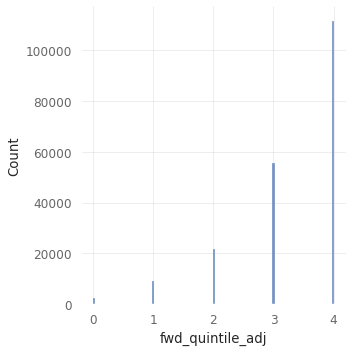

In [35]:
sns.displot(final_stock_data[Y_name])

In [36]:
from sklearn.utils import class_weight

class_weights= class_weight.compute_class_weight('balanced', np.sort(final_stock_data[Y_name].unique()), final_stock_data[Y_name])
class_weights_dict  ={0:class_weights[0],1:class_weights[1],2:class_weights[2],3:class_weights[3],4:class_weights[4]}
class_weights_dict

/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4], y=date
1986-04    3
1986-05    3
1986-06    2
1986-07    2
1986-08    2
          ..
2020-06    4
2020-07    4
2020-08    4
2020-09    4
2020-10    4
Name: fwd_quintile_adj, Length: 200393, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


{0: 17.68693733451015,
 1: 4.343151278716949,
 2: 1.85781300699949,
 3: 0.7196215032139908,
 4: 0.359024294109216}

## Find optimal adam learning rate 

In [ ]:
# """def compile_and_fit_simple(model_type,checkpoint_path,config,stock_data, x_train_factors,x_train_macro,x_train_merged,y_train, patience, batch_size, num_epochs, goal):"""


# model_history_LSTM_model_merged_1L = compile_and_fit_simple('merged',checkpoints_LSTM_model_merged_1L,config,final_stock_data,x_train_factors,x_train_macro,x_train_merged,y_train,  2, batch_size, 
#                     100, 'lr', class_weights_dict)
# model_history_LSTM_model_merged_2L = compile_and_fit_simple('merged',checkpoints_LSTM_model_merged_2L,config,final_stock_data,x_train_factors,x_train_macro,x_train_merged,y_train, 2, batch_size, 
#                     100,'lr',class_weights_dict)
# model_history_LSTM_model_merged_3L = compile_and_fit_simple('merged',checkpoints_LSTM_model_merged_3L,config,final_stock_data,x_train_factors,x_train_macro,x_train_merged,y_train, 2, batch_size, 
#                     100,'lr',class_weights_dict)
# model_history_LSTM_model_merged_4L = compile_and_fit_simple('merged',checkpoints_LSTM_model_merged_4L,config,final_stock_data,x_train_factors,x_train_macro,x_train_merged,y_train,  2, batch_size, 
#                     100,'lr',class_weights_dict)

In [ ]:
# lrs = 1e-4*(10**(tf.range(20)/20))
# plt.figure(figsize=(20,10))
# plt.semilogx(lrs, model_history_LSTM_model_merged_1L.history['loss'])
# plt.xlabel('learningrate')
# plt.ylable('loss')

## Fitting Feedforward models

### Merged Feedforward NNs looped

In [ ]:

"""compile_and_fit_simple_loop(model_type,checkpoint_path,config,final_stock_data, x_train_factors,x_train_macro,x_train_merged,y_train, x_val_factors,x_val_macro,x_val_merged,y_val, patience, 
                                batch_size, num_epochs, Y_name):"""


model_history_model_merged_1L_loop = compile_and_fit_simple_loop('merged',checkpoints_model_merged_1L_loop,config,final_stock_data,x_train_factors_loop,x_train_macro_loop,x_train_merged_loop,y_train_loop, x_val_factors_loop,x_val_macro_loop,x_val_merged_loop,y_val_loop, patience_value, batch_size, 
                    100,'fit',class_weights_dict)
model_history_model_merged_2L_loop = compile_and_fit_simple_loop('merged',checkpoints_model_merged_2L_loop,config,final_stock_data,x_train_factors_loop,x_train_macro_loop,x_train_merged_loop,y_train_loop, x_val_factors_loop,x_val_macro_loop,x_val_merged_loop,y_val_loop,  patience_value, batch_size, 
                    100,'fit',class_weights_dict)
model_history_model_merged_3L_loop = compile_and_fit_simple_loop('merged',checkpoints_model_merged_3L_loop,config,final_stock_data,x_train_factors_loop,x_train_macro_loop,x_train_merged_loop,y_train_loop, x_val_factors_loop,x_val_macro_loop,x_val_merged_loop,y_val_loop,  patience_value, batch_size, 
                    100,'fit',class_weights_dict)
model_history_model_merged_4L_loop = compile_and_fit_simple_loop('merged',checkpoints_model_merged_4L_loop,config,final_stock_data,x_train_factors_loop,x_train_macro_loop,x_train_merged_loop,y_train_loop, x_val_factors_loop,x_val_macro_loop,x_val_merged_loop,y_val_loop,  patience_value, batch_size, 
                    100,'fit',class_weights_dict)

In [ ]:
file_saver('checkpoints_model_merged_1L_loop_final.h5', 'checkpoints_model_merged_1L_loop_final.h5')
file_saver('checkpoints_model_merged_2L_loop_final.h5', 'checkpoints_model_merged_2L_loop_final.h5')
file_saver('checkpoints_model_merged_3L_loop_final.h5', 'checkpoints_model_merged_3L_loop_final.h5')
file_saver('checkpoints_model_merged_4L_loop_final.h5', 'checkpoints_model_merged_4L_loop_final.h5')

file_saver('checkpoints_model_merged_1L_loop.h5', 'checkpoints_model_merged_1L_loop.h5')
file_saver('checkpoints_model_merged_2L_loop.h5', 'checkpoints_model_merged_2L_loop.h5')
file_saver('checkpoints_model_merged_3L_loop.h5', 'checkpoints_model_merged_3L_loop.h5')
file_saver('checkpoints_model_merged_4L_loop.h5', 'checkpoints_model_merged_4L_loop.h5')

### Factor Feedforward NNs looped

In [ ]:
"""nn_predict_simple_loop(model_type,test_data_stocks, x_test_factors,x_test_macro,x_test_merged, model_path, batch_size, label_names)"""

In [ ]:
model_history_model_1L_loop= compile_and_fit_simple_loop('factors',checkpoints_model_1L_loop,final_stock_data,x_train_factors_loop,x_train_macro_loop,x_train_merged_loop,y_train_loop, x_val_factors_loop,x_val_macro_loop,x_val_merged_loop,y_val_loop,  patience_value, batch_size, 
                    100,'fit')
model_history_model_2L_loop = compile_and_fit_simple_loop('factors',checkpoints_model_2L_loop,config,final_stock_data,x_train_factors_loop,x_train_macro_loop,x_train_merged_loop,y_train_loop, x_val_factors_loop,x_val_macro_loop,x_val_merged_loop,y_val_loop, patience_value, batch_size, 
                    100,'fit')
model_history_model_3L_loop = compile_and_fit_simple_loop('factors',checkpoints_model_3L_loop,config,final_stock_data,x_train_factors_loop,x_train_macro_loop,x_train_merged_loop,y_train_loop, x_val_factors_loop,x_val_macro_loop,x_val_merged_loop,y_val_loop,  patience_value, batch_size, 
                    100,'fit')
model_history_model_4L_loop = compile_and_fit_simple_loop('factors',checkpoints_model_4L_loop,config,final_stock_data,x_train_factors_loop,x_train_macro_loop,x_train_merged_loop,y_train_loop, x_val_factors_loop,x_val_macro_loop,x_val_merged_loop,y_val_loop, patience_value, batch_size, 
                    100,'fit')

In [ ]:
file_saver('checkpoints_model_1L_loop_final.h5', 'checkpoints_model_1L_loop_final.h5')
file_saver('checkpoints_model_1L_loop_final.h5', 'checkpoints_model_1L_loop_final.h5')
file_saver('checkpoints_model_1L_loop_final.h5', 'checkpoints_model_1L_loop_final.h5')
file_saver('checkpoints_model_1L_loop_final.h5', 'checkpoints_model_1L_loop_final.h5')

file_saver('checkpoints_model_1L_loop.h5', 'checkpoints_model_1L_loop.h5')
file_saver('checkpoints_model_1L_loop.h5', 'checkpoints_model_1L_loop.h5')
file_saver('checkpoints_model_1L_loop.h5', 'checkpoints_model_1L_loop.h5')
file_saver('checkpoints_model_1L_loop.h5', 'checkpoints_model_1L_loop.h5')

### LSTM merged looped 

In [41]:

"""compile_and_fit_simple_loop(model_type,checkpoint_path,config,stock_data, x_train_factors,x_train_macro,x_train_merged,y_train, patience, 
                                batch_size, num_epochs, goal, class_weights_dict):
    """


model_history_LSTM_model_merged_1L_loop = compile_and_fit_simple_loop('merged',checkpoints_LSTM_model_merged_1L_loop,config,final_stock_data,x_train_factors_loop,x_train_macro_loop,x_train_merged_loop,y_train_loop, patience_value, batch_size, 
                    100,'fit',class_weights_dict)
model_history_LSTM_model_merged_2L_loop = compile_and_fit_simple_loop('merged',checkpoints_LSTM_model_merged_2L_loop,config,final_stock_data,x_train_factors_loop,x_train_macro_loop,x_train_merged_loop,y_train_loop,  patience_value, batch_size, 
                    100,'fit',class_weights_dict)
model_history_LSTM_model_merged_3L_loop = compile_and_fit_simple_loop('merged',checkpoints_LSTM_model_merged_3L_loop,config,final_stock_data,x_train_factors_loop,x_train_macro_loop,x_train_merged_loop,y_train_loop,  patience_value, batch_size, 
                    100,'fit',class_weights_dict)
model_history_LSTM_model_merged_4L_loop = compile_and_fit_simple_loop('merged',checkpoints_LSTM_model_merged_4L_loop,config,final_stock_data,x_train_factors_loop,x_train_macro_loop,x_train_merged_loop,y_train_loop,  patience_value, batch_size, 
                    100,'fit',class_weights_dict)

fitting to:  0
fitting to:  1
fitting to:  2
fitting to:  3
fitting to:  4
fitting to:  5
fitting to:  6
fitting to:  7
fitting to:  8
fitting to:  9
fitting to:  10
fitting to:  11
fitting to:  12
fitting to:  13
fitting to:  14
fitting to:  15
fitting to:  16
fitting to:  17
fitting to:  18
fitting to:  19
fitting to:  20
fitting to:  21
fitting to:  22
fitting to:  23
fitting to:  24
fitting to:  25
fitting to:  26
fitting to:  27
fitting to:  28
fitting to:  29
fitting to:  30
fitting to:  31
fitting to:  32
fitting to:  33
fitting to:  34
fitting to:  35
fitting to:  36
fitting to:  37
fitting to:  38
fitting to:  39
fitting to:  40
fitting to:  41
fitting to:  42
fitting to:  43
fitting to:  44
fitting to:  45
fitting to:  46
fitting to:  47
fitting to:  48
fitting to:  49
fitting to:  50
fitting to:  51
fitting to:  52
fitting to:  53
fitting to:  54
fitting to:  55
fitting to:  56
fitting to:  57
fitting to:  58
fitting to:  59
fitting to:  60
fitting to:  61
fitting to:  62
fi

In [44]:
# file_saver('checkpoints_loop/checkpoints_LSTM_model_merged_1L_loop_final.h5', 'checkpoints_loop/checkpoints_LSTM_model_merged_1L_loop_final.h5')
# file_saver('checkpoints_loop/checkpoints_LSTM_model_merged_2L_loop_final.h5', 'checkpoints_loop/checkpoints_LSTM_model_merged_2L_loop_final.h5')
# file_saver('checkpoints_loop/checkpoints_LSTM_model_merged_3L_loop_final.h5', 'checkpoints_loop/checkpoints_LSTM_model_merged_3L_loop_final.h5')
# file_saver('checkpoints_loop/checkpoints_LSTM_model_merged_4L_loop_final.h5', 'checkpoints_loop/checkpoints_LSTM_model_merged_4L_loop_final.h5')

# file_saver('checkpoints_loop/checkpoints_LSTM_model_merged_1L_loop.h5', 'checkpoints_loop/checkpoints_LSTM_model_merged_1L_loop.h5')
# file_saver('checkpoints_loop/checkpoints_LSTM_model_merged_2L_loop.h5', 'checkpoints_loop/checkpoints_LSTM_model_merged_2L_loop.h5')
# file_saver('checkpoints_loop/checkpoints_LSTM_model_merged_3L_loop.h5', 'checkpoints_loop/checkpoints_LSTM_model_merged_3L_loop.h5')
# file_saver('checkpoints_loop/checkpoints_LSTM_model_merged_4L_loop.h5', 'checkpoints_loop/checkpoints_LSTM_model_merged_4L_loop.h5')

### Factor LSTM looped

In [50]:
# def compile_and_fit_simple_loop(model_type,checkpoint_path,config,stock_data, x_train_factors,x_train_macro,x_train_merged,y_train, patience, 
#                                 batch_size, num_epochs, goal, class_weights_dict):

In [39]:
model_history_LSTM_model_1L= compile_and_fit_simple_loop('factors',checkpoints_LSTM_model_1L_loop,config,final_stock_data,x_train_factors_loop,x_train_macro_loop,x_train_merged_loop,y_train_loop,  patience_value, batch_size, 
                    100,'fit', class_weights_dict)
model_history_LSTM_model_2L = compile_and_fit_simple_loop('factors',checkpoints_LSTM_model_2L_loop,config,final_stock_data,x_train_factors_loop,x_train_macro_loop,x_train_merged_loop, y_train_loop,patience_value, batch_size, 
                    100,'fit', class_weights_dict)
model_history_LSTM_model_3L = compile_and_fit_simple_loop('factors',checkpoints_LSTM_model_3L_loop,config,final_stock_data,x_train_factors_loop,x_train_macro_loop,x_train_merged_loop, y_train_loop, patience_value, batch_size, 
                    100,'fit',class_weights_dict)
model_history_LSTM_model_4L = compile_and_fit_simple_loop('factors',checkpoints_LSTM_model_4L_loop,config,final_stock_data,x_train_factors_loop,x_train_macro_loop,x_train_merged_loop,y_train_loop, patience_value, batch_size, 
                    100,'fit',class_weights_dict)

NameError: name 'config' is not defined

In [ ]:
file_saver('checkpoints_LSTM_model_1L_loop_final.h5', 'checkpoints_LSTM_model_1L_loop_final.h5')
file_saver('checkpoints_LSTM_model_2L_loop_final.h5', 'checkpoints_LSTM_model_2L_loop_final.h5')
file_saver('checkpoints_LSTM_model_3L_loop_final.h5', 'checkpoints_LSTM_model_3L_loop_final.h5')
file_saver('checkpoints_LSTM_model_4L_loop_final.h5', 'checkpoints_LSTM_model_4L_loop_final.h5')

file_saver('checkpoints_LSTM_model_1L_loop.h5', 'checkpoints_LSTM_model_1L_loop.h5')
file_saver('checkpoints_LSTM_model_2L_loop.h5', 'checkpoints_LSTM_model_2L_loop.h5')
file_saver('checkpoints_LSTM_model_3L_loop.h5', 'checkpoints_LSTM_model_3L_loop.h5')
file_saver('checkpoints_LSTM_model_4L_loop.h5', 'checkpoints_LSTM_model_4L_loop.h5')

### Combined FFN & LSTM looped

In [ ]:

model_history_FFN_model_L1 = compile_and_fit_simple_loop('combined',checkpoints_FFN_model_L1_loop,config,final_stock_data,x_train_factors_loop,x_train_macro_loop,x_train_merged_loop,y_train_loop, x_val_factors_loop,x_val_macro_loop,x_val_merged_loop,y_val_loop,patience_value, batch_size, 
                    100,'fit')
model_history_FFN_model_L2 = compile_and_fit_simple_loop('combined',checkpoints_FFN_model_L2_loop,config,final_stock_data,x_train_factors_loop,x_train_macro_loop,x_train_merged_loop,y_train_loop, x_val_factors_loop,x_val_macro_loop,x_val_merged_loop,y_val_loop,  patience_value, batch_size, 
                    100,'fit')
model_history_FFN_model_L3 = compile_and_fit_simple_loop('combined',checkpoints_FFN_model_L3_loop,config,final_stock_data,x_train_factors_loop,x_train_macro_loop,x_train_merged_loop,y_train_loop, x_val_factors_loop,x_val_macro_loop,x_val_merged_loop,y_val_loop, patience_value, batch_size, 
                    100,'fit')
model_history_FFN_model_L4 = compile_and_fit_simple_loop('combined',checkpoints_FFN_model_L4_loop,config,final_stock_data,x_train_factors_loop,x_train_macro_loop,x_train_merged_loop,y_train_loop, x_val_factors_loop,x_val_macro_loop,x_val_merged_loop,y_val_loop, patience_value, batch_size, 
                    100,'fit')

In [ ]:
file_saver('checkpoints_FFN_model_L1_loop_final.h5', 'checkpoints_FFN_model_L1_loop_final.h5')
file_saver('checkpoints_FFN_model_L2_loop_final.h5', 'checkpoints_FFN_model_L2_loop_final.h5')
file_saver('checkpoints_FFN_model_L3_loop_final.h5', 'checkpoints_FFN_model_L3_loop_final.h5')
file_saver('checkpoints_FFN_model_L4_loop_final.h5', 'checkpoints_FFN_model_L4_loop_final.h5')

file_saver('checkpoints_FFN_model_L1_loop.h5', 'checkpoints_FFN_model_L1_loop.h5')
file_saver('checkpoints_FFN_model_L2_loop.h5', 'checkpoints_FFN_model_L2_loop.h5')
file_saver('checkpoints_FFN_model_L3_loop.h5', 'checkpoints_FFN_model_L3_loop.h5')
file_saver('checkpoints_FFN_model_L4_loop.h5', 'checkpoints_FFN_model_L4_loop.h5')

# Create Test Data 

In [57]:
test_data_loop  = get_test_data_stocks_loop(final_stock_data, batch_size, 0.8)
test_data_loop

100%|██████████| 501/501 [00:00<00:00, 605.97it/s]


,permno,prc,ret,shrout,mktcap,vweights,ret_mk,monthly_exret,fwd_monthly_exret,quintile,fwd_quintile,fwd_quintile_adj
date,,,,,,,,,,,,
2014-08,10104.0,41.529999,0.028225,4454889.0,1.850115e+08,0.006780,0.041170,-0.012945,-0.056919,4,4,3
2014-09,10104.0,38.279999,-0.078257,4431304.0,1.696303e+08,0.006779,-0.021337,-0.056919,-0.004142,4,4,3
2014-10,10104.0,39.049999,0.023250,4431304.0,1.730424e+08,0.007223,0.027391,-0.004142,0.058629,4,4,3
2014-11,10104.0,42.410000,0.086044,4431304.0,1.879316e+08,0.007638,0.027415,0.058629,0.061811,4,4,3
2014-12,10104.0,44.970001,0.060363,4391367.0,1.974798e+08,0.007340,-0.001448,0.061811,-0.044355,4,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06,92655.0,294.950012,-0.028375,948380.0,2.797247e+08,0.008455,0.027283,-0.055658,-0.033264,5,5,4
2020-07,92655.0,302.779999,0.026547,948380.0,2.871505e+08,0.008236,0.059811,-0.033264,-0.037238,5,5,4
2020-08,92655.0,312.549988,0.032268,950336.0,2.970275e+08,0.008534,0.069506,-0.037238,0.033372,5,5,4


In [39]:
test_array = np.load('test_arrays_seperate_sp.npz',allow_pickle=True)
x_test_merged_loop = test_array['x_test_merged']
x_test_factors_loop =test_array['x_test_factors']
x_test_macro_loop = test_array['x_test_macro']
y_test_loop = test_array['y_test']

In [ ]:
"""nn_predict(model_type,data_stocks, factor_data,macro_data, merged_data, model_path, batch_size)"""

In [65]:
test_data_loop.max()

permno               9.265500e+04
prc                  4.168340e+03
ret                  4.849498e-01
shrout               1.710254e+07
mktcap               2.206911e+09
vweights             6.119655e-02
ret_mk               1.284342e-01
monthly_exret        4.504670e-01
fwd_monthly_exret    4.508749e-01
quintile             5.000000e+00
fwd_quintile         5.000000e+00
fwd_quintile_adj     4.000000e+00
dtype: float64

In [63]:
predictions_LSTM_model_merged_1L_loop.max()

# r2_score(test_data_loop)

date                                                  2020-10
permno                                                92655.0
pred_loop/checkpoints_LSTM_model_merged_1L_loop.h5          5
dtype: object

In [58]:
# predictions using merged dataset of factor and macro data and LSTM
predictions_LSTM_model_merged_1L_loop = nn_predict_simple_loop('merged',test_data_loop, x_test_factors_loop,x_test_macro_loop,x_test_merged_loop, checkpoints_LSTM_model_merged_1L_loop, batch_size, label_names)
predictions_LSTM_model_merged_2L_loop = nn_predict_simple_loop('merged',test_data_loop, x_test_factors_loop,x_test_macro_loop,x_test_merged_loop, checkpoints_LSTM_model_merged_2L_loop, batch_size, label_names)
predictions_LSTM_model_merged_3L_loop = nn_predict_simple_loop('merged',test_data_loop, x_test_factors_loop,x_test_macro_loop,x_test_merged_loop, checkpoints_LSTM_model_merged_3L_loop, batch_size, label_names)
predictions_LSTM_model_merged_4L_loop = nn_predict_simple_loop('merged',test_data_loop, x_test_factors_loop,x_test_macro_loop,x_test_merged_loop,checkpoints_LSTM_model_merged_4L_loop, batch_size, label_names)

# #predictions only using factor data and LSTM
# predictions_LSTM_model_1L_loop = nn_predict_simple_loop('factors',test_data_loop, x_test_factors_loop,x_test_macro_loop,x_test_merged_loop,  checkpoints_LSTM_model_1L_loop, batch_size)
# predictions_LSTM_model_2L_loop = nn_predict_simple_loop('factors',test_data_loop, x_test_factors_loop,x_test_macro_loop,x_test_merged_loop,  checkpoints_LSTM_model_2L_loop, batch_size)
# predictions_LSTM_model_3L_loop = nn_predict_simple_loop('factors',test_data_loop, x_test_factors_loop,x_test_macro_loop,x_test_merged_loop,  checkpoints_LSTM_model_3L_loop, batch_size)
# predictions_LSTM_model_4L_loop = nn_predict_simple_loop('factors',test_data_loop, x_test_factors_loop,x_test_macro_loop,x_test_merged_loop,  checkpoints_LSTM_model_4L_loop, batch_size)

# #predictions Feedforward + LSTM
# predictions_FFN_model_L1_loop = nn_predict_simple_loop('combined',test_data_loop, x_test_factors_loop,x_test_macro_loop,x_test_merged_loop,  checkpoints_FFN_model_L1_loop, batch_size)
# predictions_FFN_model_L2_loop = nn_predict_simple_loop('combined',test_data_loop, x_test_factors_loop,x_test_macro_loop,x_test_merged_loop,checkpoints_FFN_model_L2_loop, batch_size)
# predictions_FFN_model_L3_loop = nn_predict_simple_loop('combined',test_data_loop, x_test_factors_loop,x_test_macro_loop,x_test_merged_loop,checkpoints_FFN_model_L3_loop, batch_size)
# predictions_FFN_model_L4_loop = nn_predict_simple_loop('combined',test_data_loop, x_test_factors_loop,x_test_macro_loop,x_test_merged_loop,checkpoints_FFN_model_L4_loop, batch_size)

predicting:  0
predicting:  1
predicting:  2
predicting:  3
predicting:  4
predicting:  5
predicting:  6
predicting:  7
predicting:  8
predicting:  9
predicting:  10
predicting:  11
predicting:  12
predicting:  13
predicting:  14
predicting:  15
predicting:  16
predicting:  17
predicting:  18
predicting:  19
predicting:  20
predicting:  21
predicting:  22
predicting:  23
predicting:  24
predicting:  25
predicting:  26
predicting:  27
predicting:  28
predicting:  29
predicting:  30
predicting:  31
predicting:  32
predicting:  33
predicting:  34
predicting:  35
predicting:  36
predicting:  37
predicting:  38
predicting:  39
predicting:  40
predicting:  41
predicting:  42
predicting:  43
predicting:  44
predicting:  45
predicting:  46
predicting:  47
predicting:  48
predicting:  49
predicting:  50
predicting:  51
predicting:  52
predicting:  53
predicting:  54
predicting:  55
predicting:  56
predicting:  57
predicting:  58
predicting:  59
predicting:  60
predicting:  61
predicting:  62
pr

## Rounding predictions

In [ ]:
predictions_LSTM_model_merged_1L_loop['pred_LSTM_model_merged_1L_loop'] = np.round(predictions_LSTM_model_merged_1L_loop['pred_LSTM_model_merged_1L_loop'])
predictions_LSTM_model_merged_2L_loop['pred_LSTM_model_merged_2L_loop'] = np.round(predictions_LSTM_model_merged_2L_loop['pred_LSTM_model_merged_2L_loop'])
predictions_LSTM_model_merged_3L_loop['pred_LSTM_model_merged_3L_loop'] = np.round(predictions_LSTM_model_merged_3L_loop['pred_LSTM_model_merged_3L_loop'])
predictions_LSTM_model_merged_4L_loop['pred_LSTM_model_merged_4L_loop'] = np.round(predictions_LSTM_model_merged_4L_loop['pred_LSTM_model_merged_4L_loop'])

predictions_LSTM_model_1L_loop['pred_LSTM_model_1L_loop'] = np.round(predictions_LSTM_model_1L_loop['pred_LSTM_model_1L_loop'])
predictions_LSTM_model_2L_loop['pred_LSTM_model_2L_loop'] = np.round(predictions_LSTM_model_2L_loop['pred_LSTM_model_2L_loop'])
predictions_LSTM_model_3L_loop['pred_LSTM_model_3L_loop'] = np.round(predictions_LSTM_model_3L_loop['pred_LSTM_model_3L_loop'])
predictions_LSTM_model_4L_loop['pred_LSTM_model_4L_loop'] = np.round(predictions_LSTM_model_4L_loop['pred_LSTM_model_4L_loop'])

predictions_FFN_model_L1_loop['pred_FFN_model_L1_loop'] = np.round(predictions_FFN_model_L1_loop['pred_FFN_model_L1_loop'])
predictions_FFN_model_L2_loop['pred_FFN_model_L2_loop']= np.round(predictions_FFN_model_L2_loop['pred_FFN_model_L2_loop'])
predictions_FFN_model_L3_loop['pred_FFN_model_L3_loop'] = np.round(predictions_FFN_model_L3_loop['pred_FFN_model_L3_loop'])
predictions_FFN_model_L4_loop['pred_FFN_model_L4_loop'] = np.round(predictions_FFN_model_L4_loop['pred_FFN_model_L4_loop'])

# Creating Metrics 

In [ ]:
""" create_metrics(test_data_df, prediction_df, batch_size, n_factors, r2_oos,dataframe_name, Y_name) """

In [ ]:
LSTM_model_merged_1L_results_loop, LSTM_model_merged_1L_metrics_loop = create_metrics(test_data_loop, predictions_LSTM_model_merged_1L_loop, batch_size,n_factors, r2_oos, 'LSTM_merged_1L_metrics', Y_name, scaler)
LSTM_model_merged_2L_results_loop, LSTM_model_merged_2L_metrics_loop = create_metrics(test_data_loop, predictions_LSTM_model_merged_2L_loop, batch_size,n_factors, r2_oos, 'LSTM_merged_2L_metrics', Y_name, scaler)
LSTM_model_merged_3L_results_loop, LSTM_model_merged_3L_metrics_loop = create_metrics(test_data_loop, predictions_LSTM_model_merged_3L_loop, batch_size,n_factors, r2_oos, 'LSTM_merged_3L_metrics', Y_name, scaler)
LSTM_model_merged_4L_results_loop, LSTM_model_merged_4L_metrics_loop = create_metrics(test_data_loop, predictions_LSTM_model_merged_4L_loop, batch_size,n_factors, r2_oos, 'LSTM_merged_4L_metrics', Y_name, scaler)

LSTM_model_1L_results_loop, LSTM_model_1L_metrics = create_metrics(test_data_loop, predictions_LSTM_model_1L_loop, batch_size,n_factors, r2_oos, 'LSTM_1L_metrics', Y_name, scaler)
LSTM_model_2L_results_loop, LSTM_model_2L_metrics = create_metrics(test_data_loop, predictions_LSTM_model_2L_loop, batch_size,n_factors, r2_oos, 'LSTM_2L_metrics', Y_name, scaler)
LSTM_model_3L_results_loop, LSTM_model_3L_metrics = create_metrics(test_data_loop, predictions_LSTM_model_3L_loop, batch_size,n_factors, r2_oos, 'LSTM_3L_metrics', Y_name, scaler)
LSTM_model_4L_results_loop, LSTM_model_4L_metrics = create_metrics(test_data_loop, predictions_LSTM_model_4L_loop, batch_size,n_factors, r2_oos, 'LSTM_4L_metrics', Y_name, scaler)

FFN_model_L1_results_loop, FFN_model_L1_metrics = create_metrics(test_data_loop, predictions_FFN_model_L1_loop, batch_size,n_factors, r2_oos, 'FFN_model_L1_metrics', Y_name, scaler)
FFN_model_L2_results_loop, FFN_model_L2_metrics = create_metrics(test_data_loop, predictions_FFN_model_L2_loop, batch_size,n_factors, r2_oos, 'FFN_model_L1_metrics', Y_name, scaler)
FFN_model_L3_results_loop, FFN_model_L3_metrics = create_metrics(test_data_loop, predictions_FFN_model_L3_loop, batch_size,n_factors, r2_oos, 'FFN_model_L1_metrics', Y_name, scaler)
FFN_model_L4_results_loop, FFN_model_L4_metrics = create_metrics(test_data_loop, predictions_FFN_model_L4_loop, batch_size,n_factors, r2_oos, 'FFN_model_L1_metrics', Y_name, scaler)

In [ ]:
"""merged model save"""
############################################################################################
LSTM_model_merged_1L_results_loop.to_csv('LSTM_model_merged_1L_results_loop.csv')
file_saver('LSTM_model_merged_1L_results_loop.csv', 'LSTM_model_merged_1L_results_loop.csv')

LSTM_model_merged_1L_metrics_loop.to_csv('LSTM_model_merged_1L_metrics_loop.csv')
file_saver('LSTM_model_merged_1L_metrics_loop.csv', 'LSTM_model_merged_1L_metrics_loop.csv')
############################################################################################

############################################################################################
LSTM_model_merged_2L_results_loop.to_csv('LSTM_model_merged_2L_results_loop.csv')
file_saver('LSTM_model_merged_2L_results_loop.csv', 'LSTM_model_merged_2L_results_loop.csv')

LSTM_model_merged_2L_metrics_loop.to_csv('LSTM_model_merged_2L_metrics_loop.csv')
file_saver('LSTM_model_merged_2L_metrics_loop.csv', 'LSTM_model_merged_2L_metrics_loop.csv')
############################################################################################

############################################################################################
LSTM_model_merged_3L_results_loop.to_csv('LSTM_model_merged_3L_results_loop.csv')
file_saver('LSTM_model_merged_3L_results_loop.csv', 'LSTM_model_merged_3L_results_loop.csv')

LSTM_model_merged_3L_metrics_loop.to_csv('LSTM_model_merged_3L_metrics_loop.csv')
file_saver('LSTM_model_merged_3L_metrics_loop.csv', 'LSTM_model_merged_3L_metrics_loop.csv')
############################################################################################

############################################################################################
LSTM_model_merged_4L_results_loop.to_csv('LSTM_model_merged_4L_results_loop.csv')
file_saver('LSTM_model_merged_4L_results_loop.csv', 'LSTM_model_merged_4L_results_loop.csv')

LSTM_model_merged_4L_metrics_loop.to_csv('LSTM_model_merged_4L_metrics_loop.csv')
file_saver('LSTM_model_merged_4L_metrics_loop.csv', 'LSTM_model_merged_4L_metrics_loop.csv')
############################################################################################

""" factor models only save"""

############################################################################################
LSTM_model_1L_results_loop.to_csv('LSTM_model_1L_results_loop.csv')
file_saver('LSTM_model_1L_results_loop.csv', 'LSTM_model_1L_results_loop.csv')

LSTM_model_1L_metrics_loop.to_csv('LSTM_model_1L_metrics_loop.csv')
file_saver('LSTM_model_1L_metrics_loop.csv', 'LSTM_model_1L_metrics_loop.csv')
############################################################################################

############################################################################################
LSTM_model_2L_results_loop.to_csv('LSTM_model_2L_results_loop.csv')
file_saver('LSTM_model_2L_results_loop.csv', 'LSTM_model_2L_results_loop.csv')

LSTM_model_2L_metrics_loop.to_csv('LSTM_model_2L_metrics_loop.csv')
file_saver('LSTM_model_2L_metrics_loop.csv', 'LSTM_model_2L_metrics_loop.csv')
############################################################################################

############################################################################################
LSTM_model_3L_results_loop.to_csv('LSTM_model_3L_results_loop.csv')
file_saver('LSTM_model_3L_results_loop.csv', 'LSTM_model_3L_results_loop.csv')

LSTM_model_3L_metrics_loop.to_csv('LSTM_model_3L_metrics_loop.csv')
file_saver('LSTM_model_3L_metrics_loop.csv', 'LSTM_model_3L_metrics_loop.csv')
############################################################################################

############################################################################################
LSTM_model_4L_results_loop.to_csv('LSTM_model_4L_results_loop.csv')
file_saver('LSTM_model_4L_results_loop.csv', 'LSTM_model_4L_results_loop.csv')

LSTM_model_4L_metrics_loop.to_csv('LSTM_model_4L_metrics_loop.csv')
file_saver('LSTM_model_4L_metrics_loop.csv', 'LSTM_model_4L_metrics_loop.csv')
############################################################################################


"""combined model save """
############################################################################################
FFN_model_L1_results_loop.to_csv('FFN_model_L1_results_loop.csv')
file_saver('FFN_model_L1_results_loop.csv', 'FFN_model_L1_results_loop.csv')

FFN_model_L1_metrics_loop.to_csv('FFN_model_L1_metrics_loop.csv')
file_saver('FFN_model_L1_metrics_loop.csv', 'FFN_model_L1_metrics_loop.csv')
############################################################################################
############################################################################################
FFN_model_L2_results_loop.to_csv('FFN_model_L2_results_loop.csv')
file_saver('FFN_model_L2_results_loop.csv', 'FFN_model_L2_results_loop.csv')

FFN_model_L2_metrics_loop.to_csv('FFN_model_L2_metrics_loop.csv')
file_saver('FFN_model_L2_metrics_loop.csv', 'FFN_model_L2_metrics_loop.csv')
############################################################################################
############################################################################################
FFN_model_L3_results_loop.to_csv('FFN_model_L3_results_loop.csv')
file_saver('FFN_model_L3_results_loop.csv', 'FFN_model_L3_results_loop.csv')

FFN_model_L3_metrics_loop.to_csv('FFN_model_L3_metrics_loop.csv')
file_saver('FFN_model_L3_metrics_loop.csv', 'FFN_model_L3_metrics_loop.csv')
############################################################################################
############################################################################################
FFN_model_L4_results_loop.to_csv('FFN_model_L4_results_loop.csv')
file_saver('FFN_model_L4_results_loop.csv', 'FFN_model_L4_results_loop.csv')

FFN_model_L4_metrics_loop.to_csv('FFN_model_L4_metrics_loop.csv')
file_saver('FFN_model_L4_metrics_loop.csv', 'FFN_model_L4_metrics_loop.csv')
############################################################################################

## Visualisation

## Neural Networks

In [ ]:
checkpoints_LSTM_model_merged_1L = 'checkpoints_LSTM_model_merged_1L'
checkpoints_LSTM_model_merged_2L = 'checkpoints_LSTM_model_merged_2L'
checkpoints_LSTM_model_merged_3L = 'checkpoints_LSTM_model_merged_3L'
checkpoints_LSTM_model_merged_4L = 'checkpoints_LSTM_model_merged_4L'

checkpoints_LSTM_model_1L = 'checkpoints_LSTM_model_1L'
checkpoints_LSTM_model_2L = 'checkpoints_LSTM_model_2L'
checkpoints_LSTM_model_3L = 'checkpoints_LSTM_model_3L'
checkpoints_LSTM_model_4L = 'checkpoints_LSTM_model_4L'

checkpoints_LSTM_model_macro_1L = 'checkpoints_LSTM_model_macro_1L'
checkpoints_LSTM_model_macro_2L = 'checkpoints_LSTM_model_macro_2L'
checkpoints_LSTM_model_macro_3L = 'checkpoints_LSTM_model_macro_3L'
checkpoints_LSTM_model_macro_4L = 'checkpoints_LSTM_model_macro_4L'

checkpoints_FFN_model_L1 = 'checkpoints_FFN_model_L1'
checkpoints_FFN_model_L2 = 'checkpoints_FFN_model_L2'
checkpoints_FFN_model_L3 = 'checkpoints_FFN_model_L3'
checkpoints_FFN_model_L4 = 'checkpoints_FFN_model_L4'

In [ ]:
model_LSTM_merged_1L = tf.keras.models.load_model(checkpoints_LSTM_model_merged_1L)
model_LSTM_merged_2L = tf.keras.models.load_model(checkpoints_LSTM_model_merged_2L)
model_LSTM_merged_3L = tf.keras.models.load_model(checkpoints_LSTM_model_merged_3L)
model_LSTM_merged_4L = tf.keras.models.load_model(checkpoints_LSTM_model_merged_4L)

model_LSTM_1L = tf.keras.models.load_model(checkpoints_LSTM_model_1L)
model_LSTM_2L = tf.keras.models.load_model(checkpoints_LSTM_model_2L)
model_LSTM_3L = tf.keras.models.load_model(checkpoints_LSTM_model_3L)
model_LSTM_4L = tf.keras.models.load_model(checkpoints_LSTM_model_4L)

model_FFN_1L = tf.keras.models.load_model(checkpoints_FFN_model_L1)
model_FFN_2L = tf.keras.models.load_model(checkpoints_FFN_model_L2)
model_FFN_3L = tf.keras.models.load_model(checkpoints_FFN_model_L3)
model_FFN_4L = tf.keras.models.load_model(checkpoints_FFN_model_L4)


xgb_model_factors = xgb.Booster()
xgb_model_factors = xgb_model_factors.load_model(XGB_factors_only_file)

xgb_model_merged = xgb.Booster()
xgb_model_merged = xgb_model_factors.load_model(XGB_factors_only_file)

In [ ]:
features_factors = final_factor_data.columns.tolist()
features_macro = final_macro_data.columns.tolist()
features_merged = features_factors +features_macro

background_factors = x_train_factors[:500]
background_macro = x_train_macro[:500]
background_merged = x_train_merged[:500]

test_factors = x_test_factors[:500] 
test_macro = x_test_macro[:500]
test_merged = x_test_merged[:500]

explainer = shap.DeepExplainer(model_LSTM_merged_1L, background_merged)
shap_values = explainer.shap_values(test_merged)
shap.summary(shap_values)
shap.bar_plot(shap_values)

explainer = shap.DeepExplainer(model_LSTM_merged_1L, background_merged)
shap_values = explainer.shap_values(test_merged)
shap.summary(shap_values)
shap.bar_plot(shap_values)

explainer = shap.DeepExplainer(model_LSTM_merged_1L, background_merged)
shap_values = explainer.shap_values(test_merged)
shap.summary(shap_values)
shap.bar_plot(shap_values)

explainer = shap.DeepExplainer(model_LSTM_merged_1L, background_merged)
shap_values = explainer.shap_values(test_merged)
shap.summary(shap_values)
shap.bar_plot(shap_values)